In [1]:
# Necessary imports :
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
import pandas as pd 
import seaborn as sns

In [2]:
def sigmoid(x):
    c = np.clip(x,-700,700)
    return 1 / (1 + np.exp(-c))
def dsigmoid(y):
    return y * (1 - y)
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

In [3]:
with h5py.File('data.h5','r') as F:
# Names variable contains the names of training and testing file 
    names = list(F.keys())
    X_train = np.array(F[names[0]][()])
    y_train = np.array(F[names[1]][()])
    X_test = np.array(F[names[2]][()])
    y_test = np.array(F[names[3]][()])

In [3]:
class Metrics: 
    """
    Necessary metrics to evaluate the model.
        Functions(labels,preds):
        * confusion_matrix
        *  accuracy_score     
    """ 
    def confusion_matrix(self,labels,preds):
        """
        Takes desireds/labels and softmax predictions,
        return a confusion matrix.
        """
        label = pd.Series(labels,name='Actual')
        pred = pd.Series(preds,name='Predicted')
        return pd.crosstab(label,pred)

    def accuracy_score(self,labels,preds): 
        """
        Takes desireds/labels and softmax predictions,
        return a accuracy_score.
        """       
        count = 0
        size = labels.shape[0]
        for i in range(size):
            if preds[i] == labels[i]:
                count +=1
        return  100 * (count/size)

    def accuracy(self,labels,preds):
        """
        Takes desireds/labels and softmax predictions,
        return a accuracy.
        """
        return 100 * (labels == preds).mean()    


In [8]:
class Activations:
    """
    Necessary activation functions for recurrent neural network(RNN,LSTM,GRU).
    """
    def relu_alternative(self,X):
        """
            Rectified linear unit activation(ReLU).
        """
        return np.maximum(X, 0)

    def ReLU(self,X):
        """
            Rectified linear unit activation(ReLU).
            Most time efficient version.
        """
        return (abs(X) + X) / 2

    def relu_another(self,X):
        """
            Rectified linear unit activation(ReLU).
        """
        return X * (X > 0)

    def tanh(self,X):
        return np.tanh(X)

    def tanh_manuel(self,X):
        """
            Hyperbolic tangent activation(tanh).
        """      
        return (np.exp(X) - np.exp(-X))/(np.exp(X) + np.exp(-X))

    def sigmoid(self,X):
        """
            Sigmoidal activation.
        """
        c = np.clip(X,-700,700)
        return 1/(1 + np.exp(-c))

    def softmax(self,X):
        """
            Stable version of softmax classifier, note that column sum is equal to 1.
        """
        e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
        
    def softmax_stable(self,X):
        """
        Less stable version of softmax activation

        """
        e_x = np.exp(X - np.max(X))
        return e_x / np.sum(e_x)

    def ReLUDerivative(self,X): 
        """
        The derivative of the ReLU function w.r.t. given input.
        """
        return 1 * (X > 0)

    def ReLU_grad(self,X):
        """
        The derivative of the ReLU function w.r.t. given input.
        """
        X[X<=0] = 0
        X[X>1] = 1
        return X

    def dReLU(self,X):  
        """
        The derivative of the ReLU function w.r.t. given input.
        """     
        return np.where(X <= 0, 0, 1)

    def dtanh(self,X): 
        """
        The derivative of the tanh function w.r.t. given input.
        """       
        return  1-(np.tanh(X)**2)

    def dsigmoid(self,X):
        """
        The derivative of the sigmoid function w.r.t. given input.
        """
        return self.sigmoid(X) * (1-self.sigmoid(X))    
    
    def softmax_stable_gradient(self,soft_out):           
        return soft_out * (1 - soft_out)

    def softmax_grad(self,softmax):        
        s = softmax.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

    def softmax_gradient(self,Sz):
        """Computes the gradient of the softmax function.
        z: (T, 1) array of input values where the gradient is computed. T is the
        number of output classes.
        Returns D (T, T) the Jacobian matrix of softmax(z) at the given z. D[i, j]
        is DjSi - the partial derivative of Si w.r.t. input j.
        """
        
        # -SjSi can be computed using an outer product between Sz and itself. Then
        # we add back Si for the i=j cases by adding a diagonal matrix with the
        # values of Si on its diagonal.
        D = -np.outer(Sz, Sz) + np.diag(Sz.flatten())
        return D

In [9]:
class RNN(object):
    """
    Recurrent Neural Network for classifying human activity.
    RNN encapsulates all necessary logic for training the network.

    """
    def __init__(self,input_dim = 3,hidden_dim = 128, seq_len = 150, learning_rate = 1e-1, mom_coeff = 0.85, batch_size = 32, output_class = 6):

        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(150)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim_inp2hid = Xavier(self.input_dim,self.hidden_dim)
        self.W1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(self.input_dim,self.hidden_dim))
        self.B1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(1,self.hidden_dim))

        lim_hid2hid = Xavier(self.hidden_dim,self.hidden_dim)
        self.W1_rec= np.random.uniform(-lim_hid2hid,lim_hid2hid,(self.hidden_dim,self.hidden_dim))

        lim_hid2out = Xavier(self.hidden_dim,self.output_class)
        self.W2 = np.random.uniform(-lim_hid2out,lim_hid2out,(self.hidden_dim,self.output_class))
        self.B2 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # Storing previous momentum updates :
        self.prev_updates = {'W1'       : 0,
                             'B1'       : 0,
                             'W1_rec'   : 0,
                             'W2'       : 0,
                             'B2'       : 0}


    def forward(self,X) -> tuple:
        """ Forward propagation of the RNN through time.
        

        Inputs:
        --- X is the bacth.
        --- h_prev_state is the previous state of the hidden layer.
        
        Returns:
        --- (X_state,hidden_state,probs) as a tuple.       
        ------ 1) X_state is the input across all time steps
        ------ 2) hidden_state is the hidden stages across time
        ------ 3) probs is the probabilities of each outputs, i.e. outputs of softmax
        """ 
        X_state = dict()
        hidden_state = dict()
        output_state = dict()
        probs = dict()

        
        self.h_prev_state = np.zeros((1,self.hidden_dim))
        hidden_state[-1] = np.copy(self.h_prev_state)

        # Loop over time T = 150 :
        for t in range(self.seq_len):

            # Selecting first record with 3 inputs, dimension = (batch_size,input_size)
            X_state[t] = X[:,t]

            # Recurrent hidden layer :
            hidden_state[t] = np.tanh(np.dot(X_state[t],self.W1) + np.dot(hidden_state[t-1],self.W1_rec) + self.B1)
            output_state[t] = np.dot(hidden_state[t],self.W2) + self.B2

            # Per class probabilites :
            probs[t] = activations.softmax(output_state[t])

        return (X_state,hidden_state,probs)
        

    def BPTT(self,cache,Y):
        """

        Back propagation through time algorihm.
        Inputs:
        -- Cache = (X_state,hidden_state,probs)
        -- Y = desired output

        Returns:
        -- Gradients w.r.t. all configurable elements
        """

        X_state,hidden_state,probs = cache

        # backward pass: compute gradients going backwards
        dW1, dW1_rec, dW2 = np.zeros_like(self.W1), np.zeros_like(self.W1_rec), np.zeros_like(self.W2)

        dB1, dB2 = np.zeros_like(self.B1), np.zeros_like(self.B2)

        dhnext = np.zeros_like(hidden_state[0])

        dy = np.copy(probs[149])      
        dy[np.arange(len(Y)),np.argmax(Y,1)] -= 1
        
        dB2 += np.sum(dy,axis = 0, keepdims = True)
        dW2 += np.dot(hidden_state[149].T,dy)

        for t in reversed(range(1,self.seq_len)):

            
        
            dh = np.dot(dy,self.W2.T) + dhnext
        
            dhrec = (1 - (hidden_state[t] * hidden_state[t])) * dh

            dB1 += np.sum(dhrec,axis = 0, keepdims = True)
            
            dW1 += np.dot(X_state[t].T,dhrec)
            
            dW1_rec += np.dot(hidden_state[t-1].T,dhrec)

            dhnext = np.dot(dhrec,self.W1_rec.T)

               
        for grad in [dW1,dB1,dW1_rec,dW2,dB2]:
            np.clip(grad, -10, 10, out = grad)


        return [dW1,dB1,dW1_rec,dW2,dB2]    
        
    def earlyStopping(self,ce_train,ce_val,ce_threshold,acc_train,acc_val,acc_threshold):
        if ce_train - ce_val < ce_threshold or acc_train - acc_val > acc_threshold:
            return True
        else:
            return False
   

    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N

    def step(self,grads,momentum = True):
        """
        SGD on mini batches
        """

     
        #for config_param,grad in zip([self.W1,self.B1,self.W1_rec,self.W2,self.B2],grads):
            #config_param -= self.learning_rate * grad

        if momentum:
            
            delta_W1 = -self.learning_rate * grads[0] +  self.mom_coeff * self.prev_updates['W1']
            delta_B1 = -self.learning_rate * grads[1] +  self.mom_coeff * self.prev_updates['B1']  
            delta_W1_rec = -self.learning_rate * grads[2] +  self.mom_coeff * self.prev_updates['W1_rec']
            delta_W2 = -self.learning_rate * grads[3] +  self.mom_coeff * self.prev_updates['W2']              
            delta_B2 = -self.learning_rate * grads[4] +  self.mom_coeff * self.prev_updates['B2']
            
               
            self.W1 += delta_W1
            self.W1_rec += delta_W1_rec
            self.W2 += delta_W2
            self.B1 += delta_B1
            self.B2 += delta_B2     

            
            self.prev_updates['W1'] = delta_W1
            self.prev_updates['W1_rec'] = delta_W1_rec
            self.prev_updates['W2'] = delta_W2
            self.prev_updates['B1'] = delta_B1
            self.prev_updates['B2'] = delta_B2

            self.learning_rate *= 0.9999

    def fit(self,X,Y,X_val,y_val,epochs = 50 ,verbose = True, earlystopping = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)           
            
            for i in range(round(X.shape[0]/self.batch_size)): 

                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size
                index = perm[batch_start:batch_finish]
                
                X_feed = X[index]    
                y_feed = Y[index]
                
                cache_train = self.forward(X_feed)                                                          
                grads = self.BPTT(cache_train,y_feed)                
                self.step(grads)
      

            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[2][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)

            _,__,probs_test = self.forward(X_val)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if earlystopping:                
                if self.earlyStopping(ce_train = cross_loss_train,ce_val = cross_loss_val,ce_threshold = 3.0,acc_train = acc_train,acc_val = acc_val,acc_threshold = 15): 
                    break
            


            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)

    def predict(self,X):
        _,__,probs = self.forward(X)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}
 

In [10]:
input_dim = 3
activations = Activations()
metrics = Metrics()
model = RNN(input_dim = input_dim,learning_rate = 1e-4, mom_coeff = 0.0, hidden_dim = 128)

In [10]:
model.fit(X_train,y_train,X_test,y_test,epochs = 35)

Epoch : 1
[1/35] ------> Training :  Accuracy : 49.5
[1/35] ------> Training :  Loss     : 1.2487549327905854
______________________________________________________________________________________

[1/35] ------> Testing  :  Accuracy : 41.66666666666667
[1/35] ------> Testing  :  Loss     : 1.3747013111841933
______________________________________________________________________________________

Epoch : 2
[2/35] ------> Training :  Accuracy : 61.133333333333326
[2/35] ------> Training :  Loss     : 1.3774637253359403
______________________________________________________________________________________

[2/35] ------> Testing  :  Accuracy : 51.66666666666667
[2/35] ------> Testing  :  Loss     : 1.1737358426528832
______________________________________________________________________________________

Epoch : 3


KeyboardInterrupt: 

In [ ]:
history = model.history()

In [ ]:
plt.figure()
plt.plot(history['TestLoss'],'-o')
plt.plot(history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Categorical Cross Entropy over epochs')
plt.legend(['Test Loss','Train Loss'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history['TestAcc'],'-o')
plt.plot(history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Accuracy over epochs')
plt.legend(['Test Acc','Train Acc'])
plt.show()

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [ ]:
confusion_mat_train = metrics.confusion_matrix(np.argmax(y_train,1),train_preds)
confusion_mat_test = metrics.confusion_matrix(np.argmax(y_test,1),test_preds)

In [ ]:
body_movements = ['downstairs','jogging','sitting','standing','upstairs','walking']
confusion_mat_train_,confusion_mat_test_ = confusion_mat_train,confusion_mat_test
confusion_mat_train.columns = body_movements
confusion_mat_train.index = body_movements
print(confusion_mat_train)

downstairs  jogging  sitting  standing  upstairs  walking
downstairs         356       16        0         1       119        8
jogging              3      488        0         0         5        4
sitting              2        1      468        27         2        0
standing             2        1        6       476        13        2
upstairs            16       25        2         0       453        4
walking             10        3        0         0        19      468

In [ ]:
confusion_mat_test.columns = body_movements
confusion_mat_test.index = body_movements
print(confusion_mat_train)

downstairs  jogging  sitting  standing  upstairs  walking
downstairs         356       16        0         1       119        8
jogging              3      488        0         0         5        4
sitting              2        1      468        27         2        0
standing             2        1        6       476        13        2
upstairs            16       25        2         0       453        4
walking             10        3        0         0        19      468

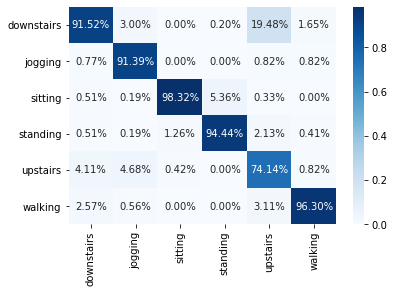

In [ ]:
sns.heatmap(confusion_mat_train/np.sum(confusion_mat_train), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

In [11]:
print(confusion_mat_test)

SyntaxError: unexpected EOF while parsing (<ipython-input-11-738c0ca9ff2d>, line 1)

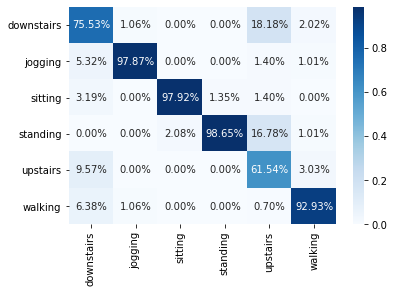

In [ ]:
sns.heatmap(confusion_mat_test/np.sum(confusion_mat_test), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

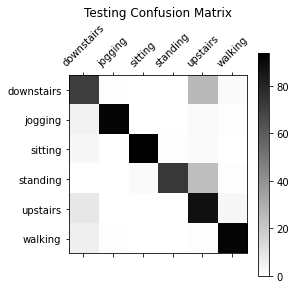

In [ ]:
plt.matshow(confusion_mat_test, cmap=plt.cm.gray_r)
plt.title('Testing Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(confusion_mat_test.columns))
plt.xticks(tick_marks, confusion_mat_test.columns, rotation=45)
plt.yticks(tick_marks, confusion_mat_test.index)
plt.tight_layout()
plt.ylabel(confusion_mat_test.index.name)
plt.xlabel(confusion_mat_test.columns.name)
plt.show()


In [ ]:
plt.matshow(confusion_mat_train, cmap=plt.cm.gray_r)
plt.title('Training Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(confusion_mat_train.columns))
plt.xticks(tick_marks, confusion_mat_train.columns, rotation=45)
plt.yticks(tick_marks, confusion_mat_train.index)
plt.tight_layout()
plt.ylabel(confusion_mat_train.index.name)
plt.xlabel(confusion_mat_train.columns.name)
plt.show()

In [ ]:
sns.heatmap(confusion_mat_test/np.sum(confusion_mat_test), annot=True, 
            fmt='.2%',cmap = 'Greens')
plt.show()

In [ ]:
sns.heatmap(confusion_mat_test/np.sum(confusion_mat_test), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

In [11]:
class Multi_Layer_RNN(object):
    """
    Recurrent Neural Network for classifying human activity.
    RNN encapsulates all necessary logic for training the network.

    """
    def __init__(self,input_dim = 3,hidden_dim_1 = 128, hidden_dim_2 = 64, seq_len = 150, learning_rate = 1e-1, mom_coeff = 0.85, batch_size = 32, output_class = 6):

        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(150)
        self.input_dim = input_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim_inp2hid = Xavier(self.input_dim,self.hidden_dim_1)
        self.W1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(self.input_dim,self.hidden_dim_1))
        self.B1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(1,self.hidden_dim_1))

        lim_hid2hid = Xavier(self.hidden_dim_1,self.hidden_dim_1)
        self.W1_rec= np.random.uniform(-lim_hid2hid,lim_hid2hid,(self.hidden_dim_1,self.hidden_dim_1))


        lim_hid2hid2 = Xavier(self.hidden_dim_1,self.hidden_dim_2)
        self.W2 = np.random.uniform(-lim_hid2hid2,lim_hid2hid2,(self.hidden_dim_1,self.hidden_dim_2))
        self.B2 = np.random.uniform(-lim_hid2hid2,lim_hid2hid2,(1,self.hidden_dim_2))

        lim_hid2out = Xavier(self.hidden_dim_2,self.output_class)
        self.W3 = np.random.uniform(-lim_hid2out,lim_hid2out,(self.hidden_dim_2,self.output_class))
        self.B3 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # Storing previous momentum updates :
        self.prev_updates = {'W1'       : 0,
                             'B1'       : 0,
                             'W1_rec'   : 0,
                             'W2'       : 0,
                             'B2'       : 0,
                             'W3'       : 0,
                             'B3'       : 0}


    def forward(self,X) -> tuple:
        """
        Forward propagation of the RNN through time.
        __________________________________________________________

        Inputs:
        --- X is the bacth.
        --- h_prev_state is the previous state of the hidden layer.
        __________________________________________________________

        Returns:
        --- (X_state,hidden_state,probs) as a tuple.       
        ------ 1) X_state is the input across all time steps
        ------ 2) hidden_state is the hidden stages across time
        ------ 3) probs is the probabilities of each outputs, i.e. outputs of softmax
        __________________________________________________________
        """ 
        X_state = dict()
        hidden_state_1 = dict()
        hidden_state_mlp = dict()
        output_state = dict()
        probs = dict()
        mlp_linear = dict()
        
        self.h_prev_state = np.zeros((1,self.hidden_dim_1))
        hidden_state_1[-1] = np.copy(self.h_prev_state)

        # Loop over time T = 150 :
        for t in range(self.seq_len):

            # Selecting first record with 3 inputs, dimension = (batch_size,input_size)
            X_state[t] = X[:,t]

            # Recurrent hidden layer :
            hidden_state_1[t] = np.tanh(np.dot(X_state[t],self.W1) + np.dot(hidden_state_1[t-1],self.W1_rec) + self.B1)
            mlp_linear[t] = np.dot(hidden_state_1[t],self.W2) + self.B2
            hidden_state_mlp[t] = activations.ReLU(mlp_linear[t])
            output_state[t] = np.dot(hidden_state_mlp[t],self.W3) + self.B3

            # Per class probabilites :
            probs[t] = activations.softmax(output_state[t])

        return (X_state,hidden_state_1,mlp_linear,hidden_state_mlp,probs)
        

    def BPTT(self,cache,Y):
        """

        Back propagation through time algorihm.
        Inputs:
        -- Cache = (X_state,hidden_state,probs)
        -- Y = desired output

        Returns:
        -- Gradients w.r.t. all configurable elements
        """

        X_state,hidden_state_1,mlp_linear,hidden_state_mlp,probs = cache

        # backward pass: compute gradients going backwards
        dW1, dW1_rec, dW2, dW3 = np.zeros_like(self.W1), np.zeros_like(self.W1_rec), np.zeros_like(self.W2),np.zeros_like(self.W3)

        dB1, dB2,dB3 = np.zeros_like(self.B1), np.zeros_like(self.B2),np.zeros_like(self.B3)

        dhnext = np.zeros_like(hidden_state_1[0])

        dy = np.copy(probs[149])        
        dy[np.arange(len(Y)),np.argmax(Y,1)] -= 1
        #dy = probs[0] - Y[0]

        dW3 += np.dot(hidden_state_mlp[149].T,dy)
        dB3 += np.sum(dy,axis = 0, keepdims = True)

        dy1 = np.dot(dy,self.W3.T) * activations.ReLU_grad(mlp_linear[149])

        dB2 += np.sum(dy1,axis = 0, keepdims = True)
        dW2 += np.dot(hidden_state_1[149].T,dy1)


        for t in reversed(range(1,self.seq_len)):

            

        
            dh = np.dot(dy1,self.W2.T) + dhnext        
            dhrec = (1 - (hidden_state_1[t] * hidden_state_1[t])) * dh

            dB1 += np.sum(dhrec,axis = 0, keepdims = True)            
            dW1 += np.dot(X_state[t].T,dhrec)
            
            dW1_rec += np.dot(hidden_state_1[t-1].T,dhrec)

            dhnext = np.dot(dhrec,self.W1_rec.T)

               
        for grad in [dW1,dB1,dW1_rec,dW2,dB2,dW3,dB3]:
            np.clip(grad, -10, 10, out = grad)


        return [dW1,dB1,dW1_rec,dW2,dB2,dW3,dB3]    
        
       

    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N

    def step(self,grads,momentum = True):

     
        #for config_param,grad in zip([self.W1,self.B1,self.W1_rec,self.W2,self.B2,self.W3,self.B3],grads):
            #config_param -= self.learning_rate * grad

        if momentum:
            
            delta_W1 = -self.learning_rate * grads[0] -  self.mom_coeff * self.prev_updates['W1']
            delta_B1 = -self.learning_rate * grads[1] -  self.mom_coeff * self.prev_updates['B1']  
            delta_W1_rec = -self.learning_rate * grads[2] -  self.mom_coeff * self.prev_updates['W1_rec']
            delta_W2 = -self.learning_rate * grads[3] - self.mom_coeff * self.prev_updates['W2']              
            delta_B2 = -self.learning_rate * grads[4] -  self.mom_coeff * self.prev_updates['B2']
            delta_W3 = -self.learning_rate * grads[5] -  self.mom_coeff * self.prev_updates['W3']
            delta_B3 = -self.learning_rate * grads[6] -  self.mom_coeff * self.prev_updates['B3']
            
               
            self.W1 += delta_W1
            self.W1_rec += delta_W1_rec
            self.W2 += delta_W2
            self.B1 += delta_B1
            self.B2 += delta_B2 
            self.W3 += delta_W3
            self.B3 += delta_B3    

            
            self.prev_updates['W1'] = delta_W1
            self.prev_updates['W1_rec'] = delta_W1_rec
            self.prev_updates['W2'] = delta_W2
            self.prev_updates['B1'] = delta_B1
            self.prev_updates['B2'] = delta_B2
            self.prev_updates['W3'] = delta_W3
            self.prev_updates['B3'] = delta_B3
            
            self.learning_rate *= 0.9999

    def fit(self,X,Y,X_val,y_val,epochs = 50 ,verbose = True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)           
            
            for i in range(round(X.shape[0]/self.batch_size)): 

                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size
                index = perm[batch_start:batch_finish]
                
                X_feed = X[index]    
                y_feed = Y[index]
                
                cache_train = self.forward(X_feed)                                                          
                grads = self.BPTT(cache_train,y_feed)                
                self.step(grads)
      
                if crossVal:
                    stop = self.cross_validation(X,val_X,Y,val_Y,threshold = 5)
                    if stop: 
                        break
            
            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[4][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)

            _,__,___,____, probs_test = self.forward(X_val)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)

    def predict(self,X):
        _,__,___,____,probs = self.forward(X)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}
 

In [12]:
multilayer_rnn = Multi_Layer_RNN(learning_rate=1e-4,mom_coeff=0.0,hidden_dim_1 = 128, hidden_dim_2 = 64)

In [13]:
multilayer_rnn.fit(X_train,y_train,X_test,y_test,epochs = 35)

Epoch : 1
[1/35] ------> Training :  Accuracy : 46.33333333333333
[1/35] ------> Training :  Loss     : 1.327466154268706
______________________________________________________________________________________

[1/35] ------> Testing  :  Accuracy : 34.5
[1/35] ------> Testing  :  Loss     : 1.383115485414113
______________________________________________________________________________________

Epoch : 2
[2/35] ------> Training :  Accuracy : 54.86666666666666
[2/35] ------> Training :  Loss     : 1.0168514457404925
______________________________________________________________________________________

[2/35] ------> Testing  :  Accuracy : 46.166666666666664
[2/35] ------> Testing  :  Loss     : 1.3074958779353112
______________________________________________________________________________________

Epoch : 3
[3/35] ------> Training :  Accuracy : 56.03333333333333
[3/35] ------> Training :  Loss     : 0.9699372290837323
___________________________________________________________________

KeyboardInterrupt: 

In [ ]:
multilayer_rnn_history = multilayer_rnn.history()

In [ ]:
plt.figure()
plt.plot(multilayer_rnn_history['TestLoss'],'-o')
plt.plot(multilayer_rnn_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Categorical Cross Entropy over epochs')
plt.legend(['Test Loss','Train Loss'])
plt.show()

In [ ]:
plt.figure()
plt.plot(multilayer_rnn_history['TestAcc'],'-o')
plt.plot(multilayer_rnn_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Accuracy over epochs')
plt.legend(['Test Acc','Train Acc'])
plt.show()

In [ ]:
plt.figure()
plt.plot(multilayer_rnn_history['TrainAcc'],'-o')
plt.plot(history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['Multi Layer RNN','Vanilla RNN'])
plt.show()


In [ ]:
plt.plot(multilayer_rnn_history['TestAcc'],'-o')
plt.plot(history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['Multi Layer RNN','Vanilla RNN'])
plt.show()

In [ ]:
train_preds_multilayer_rnn = multilayer_rnn.predict(X_train)
test_preds_multilayer_rnn = multilayer_rnn.predict(X_test)
confusion_mat_train_multilayer_rnn = metrics.confusion_matrix(np.argmax(y_train,1),train_preds_multilayer_rnn)
confusion_mat_test_multilayer_rnn = metrics.confusion_matrix(np.argmax(y_test,1),test_preds_multilayer_rnn)

body_movements = ['downstairs','jogging','sitting','standing','upstairs','walking']
confusion_mat_train_multilayer_rnn.columns = body_movements
confusion_mat_train_multilayer_rnn.index = body_movements
confusion_mat_test_multilayer_rnn.columns = body_movements
confusion_mat_test_multilayer_rnn.index = body_movements
print(confusion_mat_train_multilayer_rnn)

downstairs  jogging  sitting  standing  upstairs  walking
downstairs         468        0        1         0        25        6
jogging              7      486        0         0         3        4
sitting              3        1      468        26         1        1
standing            10        1        5       473         8        3
upstairs           143        6        3         1       333       14
walking              7        2        0         0        11      480

In [ ]:
print(confusion_mat_test_multilayer_rnn)

downstairs  jogging  sitting  standing  upstairs  walking
downstairs          92        0        0         0         5        3
jogging             10       87        0         0         1        2
sitting              0        0       97         1         2        0
standing             1        0        1        84        13        1
upstairs            33        0        0         0        62        5
walking              7        1        0         0         0       92

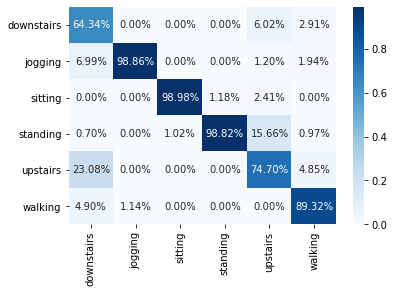

In [ ]:
sns.heatmap(confusion_mat_test_multilayer_rnn/np.sum(confusion_mat_test_multilayer_rnn), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

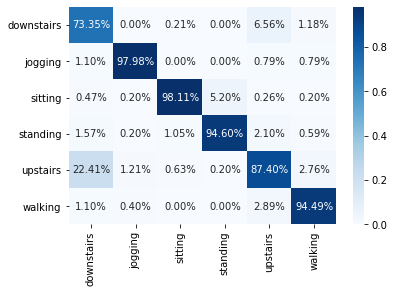

In [ ]:
sns.heatmap(confusion_mat_train_multilayer_rnn/np.sum(confusion_mat_train_multilayer_rnn), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

In [15]:
class Three_Hidden_Layer_RNN(object):
    """
    Recurrent Neural Network for classifying human activity.
    RNN encapsulates all necessary logic for training the network.

    """
    def __init__(self,input_dim = 3,hidden_dim_1 = 128, hidden_dim_2 = 64,hidden_dim_3 = 32, seq_len = 150, learning_rate = 1e-1, mom_coeff = 0.85, batch_size = 32, output_class = 6):

        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(150)
        self.input_dim = input_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.hidden_dim_3 = hidden_dim_3
        
        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim_inp2hid = Xavier(self.input_dim,self.hidden_dim_1)
        self.W1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(self.input_dim,self.hidden_dim_1))
        self.B1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(1,self.hidden_dim_1))

        lim_hid2hid = Xavier(self.hidden_dim_1,self.hidden_dim_1)
        self.W1_rec= np.random.uniform(-lim_hid2hid,lim_hid2hid,(self.hidden_dim_1,self.hidden_dim_1))


        lim_hid2hid2 = Xavier(self.hidden_dim_1,self.hidden_dim_2)
        self.W2 = np.random.uniform(-lim_hid2hid2,lim_hid2hid2,(self.hidden_dim_1,self.hidden_dim_2))
        self.B2 = np.random.uniform(-lim_hid2hid2,lim_hid2hid2,(1,self.hidden_dim_2))

        lim_hid2hid3 = Xavier(self.hidden_dim_2,self.hidden_dim_3)
        self.W3 = np.random.uniform(-lim_hid2hid3,lim_hid2hid3,(self.hidden_dim_2,self.hidden_dim_3))
        self.B3 = np.random.uniform(-lim_hid2hid3,lim_hid2hid3,(1,self.hidden_dim_3))

        lim_hid2out = Xavier(self.hidden_dim_3,self.output_class)
        self.W4 = np.random.uniform(-lim_hid2out,lim_hid2out,(self.hidden_dim_3,self.output_class))
        self.B4 = np.random.uniform(-lim_hid2out,lim_hid2out,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # Storing previous momentum updates :
        self.prev_updates = {'W1'       : 0,
                             'B1'       : 0,
                             'W1_rec'   : 0,
                             'W2'       : 0,
                             'B2'       : 0,
                             'W3'       : 0,
                             'W4'       : 0,
                             'B3'       : 0,
                             'B4'       : 0}


    def forward(self,X) -> tuple:
        """
        Forward propagation of the RNN through time.
        __________________________________________________________

        Inputs:
        --- X is the bacth.
        --- h_prev_state is the previous state of the hidden layer.
        __________________________________________________________

        Returns:
        --- (X_state,hidden_state,probs) as a tuple.       
        ------ 1) X_state is the input across all time steps
        ------ 2) hidden_state is the hidden stages across time
        ------ 3) probs is the probabilities of each outputs, i.e. outputs of softmax
        __________________________________________________________
        """ 
        X_state = dict()
        hidden_state_1 = dict()
        hidden_state_mlp = dict()
        hidden_state_mlp_2 = dict()
        output_state = dict()
        probs = dict()
        mlp_linear = dict()
        mlp_linear_2 = dict()
        
        self.h_prev_state = np.zeros((1,self.hidden_dim_1))
        hidden_state_1[-1] = np.copy(self.h_prev_state)

        # Loop over time T = 150 :
        for t in range(self.seq_len):

            # Selecting first record with 3 inputs, dimension = (batch_size,input_size)
            X_state[t] = X[:,t]

            # Recurrent hidden layer :
            hidden_state_1[t] = np.tanh(np.dot(X_state[t],self.W1) + np.dot(hidden_state_1[t-1],self.W1_rec) + self.B1)
            mlp_linear[t] = np.dot(hidden_state_1[t],self.W2) + self.B2
            hidden_state_mlp[t] = activations.ReLU(mlp_linear[t])
            mlp_linear_2[t] = np.dot(hidden_state_mlp[t],self.W3) + self.B3
            hidden_state_mlp_2[t] = activations.ReLU(mlp_linear_2[t])
            output_state[t] = np.dot(hidden_state_mlp_2[t],self.W4) + self.B4

            # Per class probabilites :
            probs[t] = activations.softmax(output_state[t])

        return (X_state,hidden_state_1,mlp_linear,hidden_state_mlp,mlp_linear_2,hidden_state_mlp_2,probs)
        

    def BPTT(self,cache,Y):
        """

        Back propagation through time algorihm.
        Inputs:
        -- Cache = (X_state,hidden_state,probs)
        -- Y = desired output

        Returns:
        -- Gradients w.r.t. all configurable elements
        """

        X_state,hidden_state_1,mlp_linear,hidden_state_mlp,mlp_linear_2,hidden_state_mlp_2,probs = cache

        # backward pass: compute gradients going backwards
        dW1, dW1_rec, dW2, dW3, dW4 = np.zeros_like(self.W1), np.zeros_like(self.W1_rec), np.zeros_like(self.W2),np.zeros_like(self.W3),np.zeros_like(self.W4)

        dB1, dB2,dB3,dB4 = np.zeros_like(self.B1), np.zeros_like(self.B2),np.zeros_like(self.B3),np.zeros_like(self.B4)

        dhnext = np.zeros_like(hidden_state_1[0])

        for t in reversed(range(1,self.seq_len)):

            dy = np.copy(probs[t])        
            dy[np.arange(len(Y)),np.argmax(Y,1)] -= 1
            #dy = probs[0] - Y[0]

            dW4 += np.dot(hidden_state_mlp_2[t].T,dy)
            dB4 += np.sum(dy,axis = 0, keepdims = True)

            dy1 = np.dot(dy,self.W4.T) * activations.ReLU_grad(mlp_linear_2[t])

            dW3 += np.dot(hidden_state_mlp[t].T,dy1)
            dB3 += np.sum(dy1,axis = 0, keepdims = True)

            dy2 = np.dot(dy1,self.W3.T) * activations.ReLU_grad(mlp_linear[t])

            dB2 += np.sum(dy2,axis = 0, keepdims = True)
            dW2 += np.dot(hidden_state_1[t].T,dy2)
        
            dh = np.dot(dy2,self.W2.T) + dhnext        
            dhrec = (1 - (hidden_state_1[t] * hidden_state_1[t])) * dh

            dB1 += np.sum(dhrec,axis = 0, keepdims = True)            
            dW1 += np.dot(X_state[t].T,dhrec)
            
            dW1_rec += np.dot(hidden_state_1[t-1].T,dhrec)

            dhnext = np.dot(dhrec,self.W1_rec.T)

               
        for grad in [dW1,dB1,dW1_rec,dW2,dB2,dW3,dB3,dW4,dB4]:
            np.clip(grad, -10, 10, out = grad)


        return [dW1,dB1,dW1_rec,dW2,dB2,dW3,dB3,dW4,dB4]    
        
       

    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N

    def step(self,grads,momentum = True):

     
        #for config_param,grad in zip([self.W1,self.B1,self.W1_rec,self.W2,self.B2,self.W3,self.B3],grads):
            #config_param -= self.learning_rate * grad

        if momentum:
            
            delta_W1 = -self.learning_rate * grads[0] +  self.mom_coeff * self.prev_updates['W1']
            delta_B1 = -self.learning_rate * grads[1] +  self.mom_coeff * self.prev_updates['B1']  
            delta_W1_rec = -self.learning_rate * grads[2] +  self.mom_coeff * self.prev_updates['W1_rec']
            delta_W2 = -self.learning_rate * grads[3] +  self.mom_coeff * self.prev_updates['W2']              
            delta_B2 = -self.learning_rate * grads[4] +  self.mom_coeff * self.prev_updates['B2']
            delta_W3 = -self.learning_rate * grads[5] +  self.mom_coeff * self.prev_updates['W3']              
            delta_B3 = -self.learning_rate * grads[6] +  self.mom_coeff * self.prev_updates['B3']
            delta_W4 = -self.learning_rate * grads[7] +  self.mom_coeff * self.prev_updates['W4']              
            delta_B4 = -self.learning_rate * grads[8] +  self.mom_coeff * self.prev_updates['B4']
            
               
            self.W1 += delta_W1
            self.W1_rec += delta_W1_rec
            self.W2 += delta_W2
            self.B1 += delta_B1
            self.B2 += delta_B2 
            self.W3 += delta_W3
            self.B3 += delta_B3   
            self.W4 += delta_W4
            self.B4 += delta_B4

            
            self.prev_updates['W1'] = delta_W1
            self.prev_updates['W1_rec'] = delta_W1_rec
            self.prev_updates['W2'] = delta_W2
            self.prev_updates['B1'] = delta_B1
            self.prev_updates['B2'] = delta_B2
            self.prev_updates['W3'] = delta_W3
            self.prev_updates['B3'] = delta_B3
            self.prev_updates['W4'] = delta_W4
            self.prev_updates['B4'] = delta_B4

            self.learning_rate *= 0.9999

    def fit(self,X,Y,X_val,y_val,epochs = 50 ,verbose = True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)           
            
            for i in range(round(X.shape[0]/self.batch_size)): 

                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size
                index = perm[batch_start:batch_finish]
                
                X_feed = X[index]    
                y_feed = Y[index]
                
                cache_train = self.forward(X_feed)                                                          
                grads = self.BPTT(cache_train,y_feed)                
                self.step(grads)
      
                if crossVal:
                    stop = self.cross_validation(X,val_X,Y,val_Y,threshold = 5)
                    if stop: 
                        break
            
            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[6][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)

            _,__,___,____,_____,______, probs_test = self.forward(X_val)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)

    def predict(self,X):
        _,__,___,____,_____,______,probs = self.forward(X)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}
 

In [16]:
three_layer_rnn = Three_Hidden_Layer_RNN(hidden_dim_1 = 128, hidden_dim_2 = 64,hidden_dim_3 = 32, learning_rate = 1e-4, mom_coeff = 0.0, batch_size = 32, output_class = 6)

In [17]:
three_layer_rnn.fit(X_train,y_train,X_test,y_test,epochs=15)

Epoch : 1
[1/15] ------> Training :  Accuracy : 51.46666666666667
[1/15] ------> Training :  Loss     : 1.3049848598384006
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 43.166666666666664
[1/15] ------> Testing  :  Loss     : 1.2721768809863985
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 61.0
[2/15] ------> Training :  Loss     : 0.8591973501774977
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 58.666666666666664
[2/15] ------> Testing  :  Loss     : 1.0449968382191452
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 63.53333333333333
[3/15] ------> Training :  Loss     : 0.7181145558082811
________________________________________________________________

In [19]:
three_layer_rnn_v1 = Three_Hidden_Layer_RNN(hidden_dim_1 = 128, hidden_dim_2 = 64,hidden_dim_3 = 32, learning_rate = 5e-5, mom_coeff = 0.0, batch_size = 32, output_class = 6)
three_layer_rnn_v1.fit(X_train,y_train,X_test,y_test,epochs=15)

Epoch : 1
[1/15] ------> Training :  Accuracy : 45.300000000000004
[1/15] ------> Training :  Loss     : 1.2258657091056624
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 35.833333333333336
[1/15] ------> Testing  :  Loss     : 1.3946158272205589
______________________________________________________________________________________

Epoch : 2


KeyboardInterrupt: 

In [18]:
three_layer_rnn_v2 = Three_Hidden_Layer_RNN(hidden_dim_1 = 128, hidden_dim_2 = 64,hidden_dim_3 = 32, learning_rate = 1e-4, mom_coeff = 0.0, batch_size = 32, output_class = 6)
three_layer_rnn_v2.fit(X_train,y_train,X_test,y_test,epochs=15)

Epoch : 1
[1/15] ------> Training :  Accuracy : 51.46666666666667
[1/15] ------> Training :  Loss     : 1.3049848598384006
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 43.166666666666664
[1/15] ------> Testing  :  Loss     : 1.2721768809863985
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 61.0
[2/15] ------> Training :  Loss     : 0.8591973501774977
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 58.666666666666664
[2/15] ------> Testing  :  Loss     : 1.0449968382191452
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 63.53333333333333
[3/15] ------> Training :  Loss     : 0.7181145558082811
________________________________________________________________

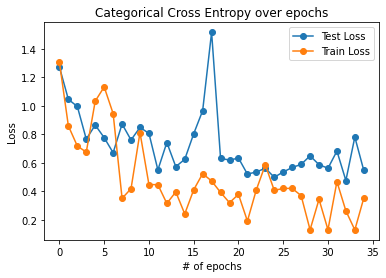

In [34]:
three_layer_rnn_history = three_layer_rnn.history()
plt.figure()
plt.plot(three_layer_rnn_history['TestLoss'],'-o')
plt.plot(three_layer_rnn_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Categorical Cross Entropy over epochs')
plt.legend(['Test Loss','Train Loss'])
plt.show()

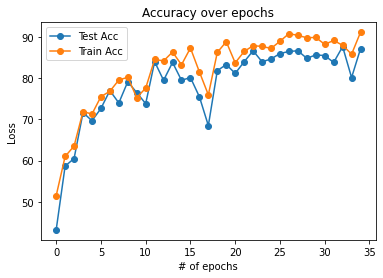

In [35]:
plt.figure()
plt.plot(three_layer_rnn_history['TestAcc'],'-o')
plt.plot(three_layer_rnn_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Accuracy over epochs')
plt.legend(['Test Acc','Train Acc'])
plt.show()

In [ ]:
plt.figure()
plt.plot(three_layer_rnn_history['TrainAcc'],'-o')
plt.plot(multilayer_rnn_history['TrainAcc'],'-o')
plt.plot(history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['3 hidden layer Rnn','Multi Layer RNN','Vanilla RNN'])
plt.show()

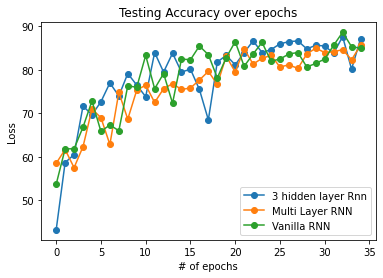

In [ ]:
plt.figure()
plt.plot(three_layer_rnn_history['TestAcc'],'-o')
plt.plot(multilayer_rnn_history['TestAcc'],'-o')
plt.plot(history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['3 hidden layer Rnn','Multi Layer RNN','Vanilla RNN'])
plt.show()

In [ ]:
train_preds_three_layer_rnn_history = three_layer_rnn.predict(X_train)
test_preds_three_layer_rnn_history = three_layer_rnn.predict(X_test)
confusion_mat_train_three_layer_rnn_history = metrics.confusion_matrix(np.argmax(y_train,1),train_preds_three_layer_rnn_history)
confusion_mat_test_three_layer_rnn_history = metrics.confusion_matrix(np.argmax(y_test,1),test_preds_three_layer_rnn_history)

body_movements = ['downstairs','jogging','sitting','standing','upstairs','walking']
confusion_mat_train_three_layer_rnn_history.columns = body_movements
confusion_mat_train_three_layer_rnn_history.index = body_movements
confusion_mat_test_three_layer_rnn_history.columns = body_movements
confusion_mat_test_three_layer_rnn_history.index = body_movements
print(confusion_mat_train_three_layer_rnn_history)

downstairs  jogging  sitting  standing  upstairs  walking
downstairs         441        4        1         4        34       16
jogging              4      486        0         0         3        7
sitting              3        0      468        27         1        1
standing             7        1        6       482         2        2
upstairs            91       14        3         4       376       12
walking              7        3        0         0         8      482

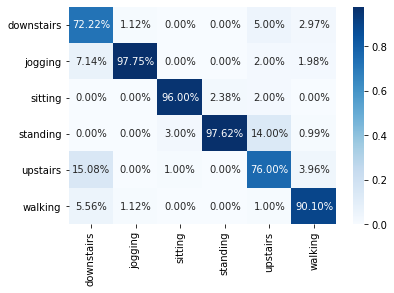

In [ ]:
sns.heatmap(confusion_mat_test_three_layer_rnn_history/np.sum(confusion_mat_test_three_layer_rnn_history), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

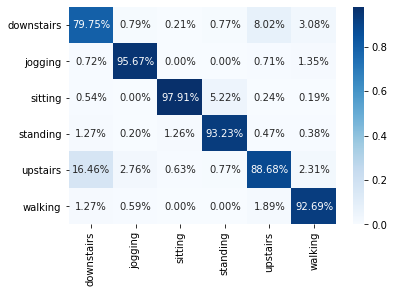

In [ ]:
sns.heatmap(confusion_mat_train_three_layer_rnn_history/np.sum(confusion_mat_train_three_layer_rnn_history), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

In [17]:
class Five_Hidden_Layer_RNN(object):
    """
    Recurrent Neural Network for classifying human activity.
    RNN encapsulates all necessary logic for training the network.

    """
    def __init__(self,input_dim = 3,hidden_dim_1 = 128, hidden_dim_2 = 64,hidden_dim_3 = 32,hidden_dim_4 = 16 ,hidden_dim_5 = 8, seq_len = 150, learning_rate = 1e-1, mom_coeff = 0.85, batch_size = 32, output_class = 6):

        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(150)
        self.input_dim = input_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.hidden_dim_3 = hidden_dim_3
        self.hidden_dim_4 = hidden_dim_4
        self.hidden_dim_5 = hidden_dim_5
        
        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim_inp2hid = Xavier(self.input_dim,self.hidden_dim_1)
        self.W1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(self.input_dim,self.hidden_dim_1))
        self.B1 = np.random.uniform(-lim_inp2hid,lim_inp2hid,(1,self.hidden_dim_1))

        lim_hid2hid = Xavier(self.hidden_dim_1,self.hidden_dim_1)
        self.W1_rec= np.random.uniform(-lim_hid2hid,lim_hid2hid,(self.hidden_dim_1,self.hidden_dim_1))


        lim_hid2hid2 = Xavier(self.hidden_dim_1,self.hidden_dim_2)
        self.W2 = np.random.uniform(-lim_hid2hid2,lim_hid2hid2,(self.hidden_dim_1,self.hidden_dim_2))
        self.B2 = np.random.uniform(-lim_hid2hid2,lim_hid2hid2,(1,self.hidden_dim_2))

        lim_hid2hid3 = Xavier(self.hidden_dim_2,self.hidden_dim_3)
        self.W3 = np.random.uniform(-lim_hid2hid3,lim_hid2hid3,(self.hidden_dim_2,self.hidden_dim_3))
        self.B3 = np.random.uniform(-lim_hid2hid3,lim_hid2hid3,(1,self.hidden_dim_3))

        lim_hid2hid4 = Xavier(self.hidden_dim_3,self.hidden_dim_4)
        self.W4 = np.random.uniform(-lim_hid2hid4,lim_hid2hid4,(self.hidden_dim_3,self.hidden_dim_4))
        self.B4 = np.random.uniform(-lim_hid2hid4,lim_hid2hid4,(1,self.hidden_dim_4))

        lim_hid2hid5 = Xavier(self.hidden_dim_4,self.hidden_dim_5)
        self.W5 = np.random.uniform(-lim_hid2hid5,lim_hid2hid5,(self.hidden_dim_4,self.hidden_dim_5))
        self.B5 = np.random.uniform(-lim_hid2hid5,lim_hid2hid5,(1,self.hidden_dim_5))


        lim_hid2out = Xavier(self.hidden_dim_5,self.output_class)
        self.W6 = np.random.uniform(-lim_hid2out,lim_hid2out,(self.hidden_dim_5,self.output_class))
        self.B6 = np.random.uniform(-lim_hid2out,lim_hid2out,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # Storing previous momentum updates :
        self.prev_updates = {'W1'       : 0,
                             'B1'       : 0,
                             'W1_rec'   : 0,
                             'W2'       : 0,
                             'B2'       : 0,
                             'W3'       : 0,
                             'W4'       : 0,
                             'B3'       : 0,
                             'B4'       : 0,
                             'W5'       : 0,
                             'W6'       : 0,
                             'B5'       : 0,
                             'B6'       : 0}


    def forward(self,X) -> tuple:
        """
        Forward propagation of the RNN through time.
        __________________________________________________________

        Inputs:
        --- X is the bacth.
        --- h_prev_state is the previous state of the hidden layer.
        __________________________________________________________

        Returns:
        --- (X_state,hidden_state,probs) as a tuple.       
        ------ 1) X_state is the input across all time steps
        ------ 2) hidden_state is the hidden stages across time
        ------ 3) probs is the probabilities of each outputs, i.e. outputs of softmax
        __________________________________________________________
        """ 
        X_state = dict()
        hidden_state_1 = dict()
        hidden_state_mlp = dict()
        hidden_state_mlp_2 = dict()
        hidden_state_mlp_3 = dict()
        hidden_state_mlp_4 = dict()
        output_state = dict()
        probs = dict()
        mlp_linear = dict()
        mlp_linear_2 = dict()
        mlp_linear_3 = dict()
        mlp_linear_4 = dict()
        
        self.h_prev_state = np.zeros((1,self.hidden_dim_1))
        hidden_state_1[-1] = np.copy(self.h_prev_state)

        # Loop over time T = 150 :
        for t in range(self.seq_len):

            # Selecting first record with 3 inputs, dimension = (batch_size,input_size)
            X_state[t] = X[:,t]

            # Recurrent hidden layer :
            hidden_state_1[t] = np.tanh(np.dot(X_state[t],self.W1) + np.dot(hidden_state_1[t-1],self.W1_rec) + self.B1)
            mlp_linear[t] = np.dot(hidden_state_1[t],self.W2) + self.B2

            hidden_state_mlp[t] = activations.ReLU(mlp_linear[t])

            mlp_linear_2[t] = np.dot(hidden_state_mlp[t],self.W3) + self.B3
            hidden_state_mlp_2[t] = activations.ReLU(mlp_linear_2[t])

            mlp_linear_3[t] = np.dot(hidden_state_mlp_2[t],self.W4) + self.B4
            hidden_state_mlp_3[t] = activations.ReLU(mlp_linear_3[t])

            mlp_linear_4[t] = np.dot(hidden_state_mlp_3[t],self.W5) + self.B5
            hidden_state_mlp_4[t] = activations.ReLU(mlp_linear_4[t])

            output_state[t] = np.dot(hidden_state_mlp_4[t],self.W6) + self.B6

            # Per class probabilites :
            probs[t] = activations.softmax(output_state[t])

        return (X_state,hidden_state_1,mlp_linear,hidden_state_mlp,mlp_linear_2,hidden_state_mlp_2,mlp_linear_3,hidden_state_mlp_3,mlp_linear_4,hidden_state_mlp_4,probs)
        

    def BPTT(self,cache,Y):
        """

        Back propagation through time algorihm.
        Inputs:
        -- Cache = (X_state,hidden_state_1,mlp_linear,hidden_state_mlp,mlp_linear_2,hidden_state_mlp_2,mlp_linear_3,hidden_state_mlp_3,mlp_linear_4,hidden_state_mlp_4,probs)
        -- Y = desired output

        Returns:
        -- Gradients w.r.t. all configurable elements
        """

        X_state,hidden_state_1,mlp_linear,hidden_state_mlp,mlp_linear_2,hidden_state_mlp_2,mlp_linear_3,hidden_state_mlp_3,mlp_linear_4,hidden_state_mlp_4,probs = cache

        # backward pass: compute gradients going backwards
        dW1, dW1_rec, dW2, dW3, dW4, dW5, dW6 = np.zeros_like(self.W1), np.zeros_like(self.W1_rec), np.zeros_like(self.W2),np.zeros_like(self.W3),np.zeros_like(self.W4),np.zeros_like(self.W5),np.zeros_like(self.W6)

        dB1, dB2,dB3,dB4,dB5,dB6 = np.zeros_like(self.B1), np.zeros_like(self.B2),np.zeros_like(self.B3),np.zeros_like(self.B4),np.zeros_like(self.B5),np.zeros_like(self.B6)

        dhnext = np.zeros_like(hidden_state_1[0])


        for t in reversed(range(1,self.seq_len)):
            
            dy = np.copy(probs[149])        
            dy[np.arange(len(Y)),np.argmax(Y,1)] -= 1
            #dy = probs[0] - Y[0]

            dW6 += np.dot(hidden_state_mlp_4[t].T,dy)
            dB6 += np.sum(dy,axis = 0, keepdims = True)

            dy1 = np.dot(dy,self.W6.T) * activations.ReLU_grad(mlp_linear_4[t])

            dW5 += np.dot(hidden_state_mlp_3[t].T,dy1)
            dB5 += np.sum(dy1,axis = 0, keepdims = True)

            dy2 = np.dot(dy1,self.W5.T) * activations.ReLU_grad(mlp_linear_3[t])

            dW4 += np.dot(hidden_state_mlp_2[t].T,dy2)
            dB4 += np.sum(dy2,axis = 0, keepdims = True)

            dy3 = np.dot(dy2,self.W4.T) * activations.ReLU_grad(mlp_linear_2[t])

            dW3 += np.dot(hidden_state_mlp[t].T,dy3)
            dB3 += np.sum(dy3,axis = 0, keepdims = True)

            dy4 = np.dot(dy3,self.W3.T) * activations.ReLU_grad(mlp_linear[t])

            dB2 += np.sum(dy4,axis = 0, keepdims = True)
            dW2 += np.dot(hidden_state_1[t].T,dy4)            
        
            dh = np.dot(dy4,self.W2.T) + dhnext        
            dhrec = (1 - (hidden_state_1[t] * hidden_state_1[t])) * dh

            dB1 += np.sum(dhrec,axis = 0, keepdims = True)            
            dW1 += np.dot(X_state[t].T,dhrec)
            
            dW1_rec += np.dot(hidden_state_1[t-1].T,dhrec)

            dhnext = np.dot(dhrec,self.W1_rec.T)

               
        for grad in [dW1,dB1,dW1_rec,dW2,dB2,dW3,dB3,dW4,dB4,dW5,dB5,dW6,dB6]:
            np.clip(grad, -10, 10, out = grad)


        return [dW1,dB1,dW1_rec,dW2,dB2,dW3,dB3,dW4,dB4,dW5,dB5,dW6,dB6]    
        
       

    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N

    def step(self,grads,momentum = True):

     
        #for config_param,grad in zip([self.W1,self.B1,self.W1_rec,self.W2,self.B2,self.W3,self.B3],grads):
            #config_param -= self.learning_rate * grad

        if momentum:
            
            delta_W1 = -self.learning_rate * grads[0] +  self.mom_coeff * self.prev_updates['W1']
            delta_B1 = -self.learning_rate * grads[1] +  self.mom_coeff * self.prev_updates['B1']  
            delta_W1_rec = -self.learning_rate * grads[2] +  self.mom_coeff * self.prev_updates['W1_rec']
            delta_W2 = -self.learning_rate * grads[3] +  self.mom_coeff * self.prev_updates['W2']              
            delta_B2 = -self.learning_rate * grads[4] +  self.mom_coeff * self.prev_updates['B2']
            delta_W3 = -self.learning_rate * grads[5] +  self.mom_coeff * self.prev_updates['W3']              
            delta_B3 = -self.learning_rate * grads[6] +  self.mom_coeff * self.prev_updates['B3']
            delta_W4 = -self.learning_rate * grads[7] +  self.mom_coeff * self.prev_updates['W4']              
            delta_B4 = -self.learning_rate * grads[8] +  self.mom_coeff * self.prev_updates['B4']
            delta_W5 = -self.learning_rate * grads[9] +  self.mom_coeff * self.prev_updates['W5']              
            delta_B5 = -self.learning_rate * grads[10] +  self.mom_coeff * self.prev_updates['B5']
            delta_W6 = -self.learning_rate * grads[11] +  self.mom_coeff * self.prev_updates['W6']              
            delta_B6 = -self.learning_rate * grads[12] +  self.mom_coeff * self.prev_updates['B6']
            
               
            self.W1 += delta_W1
            self.W1_rec += delta_W1_rec
            self.W2 += delta_W2
            self.B1 += delta_B1
            self.B2 += delta_B2 
            self.W3 += delta_W3
            self.B3 += delta_B3   
            self.W4 += delta_W4
            self.B4 += delta_B4
            self.W5 += delta_W5
            self.B5 += delta_B5
            self.W6 += delta_W6
            self.B6 += delta_B6

            
            self.prev_updates['W1'] = delta_W1
            self.prev_updates['W1_rec'] = delta_W1_rec
            self.prev_updates['W2'] = delta_W2
            self.prev_updates['B1'] = delta_B1
            self.prev_updates['B2'] = delta_B2
            self.prev_updates['W3'] = delta_W3
            self.prev_updates['B3'] = delta_B3
            self.prev_updates['W4'] = delta_W4
            self.prev_updates['B4'] = delta_B4
            self.prev_updates['W5'] = delta_W5
            self.prev_updates['B5'] = delta_B5
            self.prev_updates['W6'] = delta_W6
            self.prev_updates['B6'] = delta_B6

            self.learning_rate *= 0.9999

    def fit(self,X,Y,X_val,y_val,epochs = 50 ,verbose = True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)           
            
            for i in range(round(X.shape[0]/self.batch_size)): 

                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size
                index = perm[batch_start:batch_finish]
                
                X_feed = X[index]    
                y_feed = Y[index]
                
                cache_train = self.forward(X_feed)                                                          
                grads = self.BPTT(cache_train,y_feed)                
                self.step(grads)
      
                if crossVal:
                    stop = self.cross_validation(X,val_X,Y,val_Y,threshold = 5)
                    if stop: 
                        break
            
            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[10][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)
                                                                  
            _,__,___,____,_____,______,_______,________,__________,___________, probs_test = self.forward(X_val)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)

    def predict(self,X):
        _,__,___,____,_____,______,_______,________,__________,___________, probs = self.forward(X)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}
 

In [18]:
five_hidden_layer_rnn = Five_Hidden_Layer_RNN(hidden_dim_1 = 128, hidden_dim_2 = 64,hidden_dim_3 = 32,hidden_dim_4 = 16 ,hidden_dim_5 = 8,  learning_rate = 1e-4, mom_coeff = 0.0)

In [19]:
five_hidden_layer_rnn.fit(X_train,y_train,X_test,y_test,epochs = 35)

Epoch : 1
[1/35] ------> Training :  Accuracy : 32.266666666666666
[1/35] ------> Training :  Loss     : 1.5283905006663152
______________________________________________________________________________________

[1/35] ------> Testing  :  Accuracy : 25.666666666666664
[1/35] ------> Testing  :  Loss     : 1.5782720929857035
______________________________________________________________________________________

Epoch : 2
[2/35] ------> Training :  Accuracy : 28.066666666666666
[2/35] ------> Training :  Loss     : 1.9920290941834484
______________________________________________________________________________________

[2/35] ------> Testing  :  Accuracy : 26.166666666666664
[2/35] ------> Testing  :  Loss     : 2.1068831334866407
______________________________________________________________________________________

Epoch : 3
[3/35] ------> Training :  Accuracy : 47.93333333333333
[3/35] ------> Training :  Loss     : 2.0993887168259
____________________________________________________

KeyboardInterrupt: 

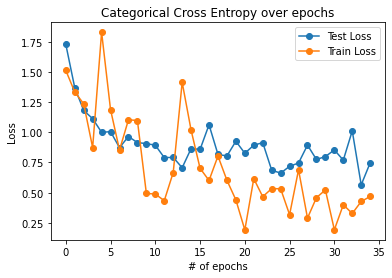

In [ ]:
five_hidden_layer_rnn_history = five_hidden_layer_rnn.history()
plt.figure()
plt.plot(five_hidden_layer_rnn_history['TestLoss'],'-o')
plt.plot(five_hidden_layer_rnn_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Categorical Cross Entropy over epochs')
plt.legend(['Test Loss','Train Loss'])
plt.show()

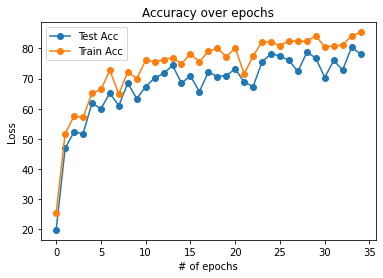

In [ ]:
plt.figure()
plt.plot(five_hidden_layer_rnn_history['TestAcc'],'-o')
plt.plot(five_hidden_layer_rnn_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Accuracy over epochs')
plt.legend(['Test Acc','Train Acc'])
plt.show()


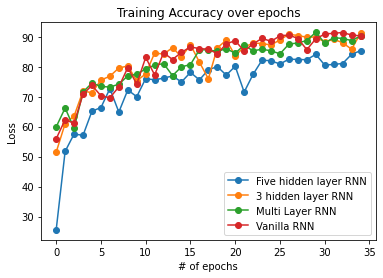

In [ ]:
plt.figure()
plt.plot(five_hidden_layer_rnn_history['TrainAcc'],'-o')
plt.plot(three_layer_rnn_history['TrainAcc'],'-o')
plt.plot(multilayer_rnn_history['TrainAcc'],'-o')
plt.plot(history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['Five hidden layer RNN','3 hidden layer RNN','Multi Layer RNN','Vanilla RNN'])
plt.show()


In [ ]:
plt.figure()
plt.plot(five_hidden_layer_rnn_history['TestAcc'],'-o')
plt.plot(three_layer_rnn_history['TestAcc'],'-o')
plt.plot(multilayer_rnn_history['TestAcc'],'-o')
plt.plot(history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['Five hidden layer RNN','3 hidden layer RNN','Multi Layer RNN','Vanilla RNN'])
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
train_preds_five_hidden_layer_rnn = five_hidden_layer_rnn.predict(X_train)
test_preds_five_hidden_layer_rnn = five_hidden_layer_rnn.predict(X_test)
confusion_mat_train_five_hidden_layer_rnn = metrics.confusion_matrix(np.argmax(y_train,1),train_preds_five_hidden_layer_rnn)
confusion_mat_test_five_hidden_layer_rnn = metrics.confusion_matrix(np.argmax(y_test,1),test_preds_five_hidden_layer_rnn)

body_movements = ['downstairs','jogging','sitting','standing','upstairs','walking']
confusion_mat_train_five_hidden_layer_rnn.columns = body_movements
confusion_mat_train_five_hidden_layer_rnn.index = body_movements
confusion_mat_test_five_hidden_layer_rnn.columns = body_movements
confusion_mat_test_five_hidden_layer_rnn.index = body_movements
print(confusion_mat_test_five_hidden_layer_rnn)

downstairs  jogging  sitting  standing  upstairs  walking
downstairs          86        0        0         0        11        3
jogging             10       88        0         0         1        1
sitting              4        0       92         0         4        0
standing             4        0        2        77        17        0
upstairs            47        0        0         0        53        0
walking             23        1        0         0         3       73

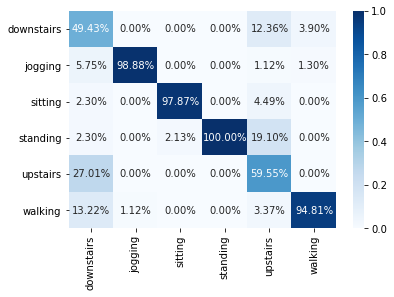

In [ ]:
sns.heatmap(confusion_mat_test_five_hidden_layer_rnn/np.sum(confusion_mat_test_five_hidden_layer_rnn), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

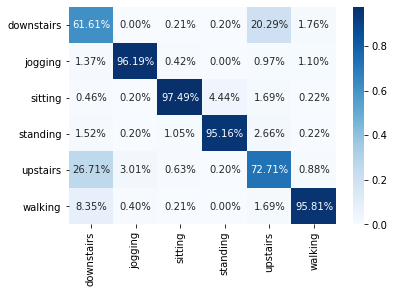

In [ ]:
sns.heatmap(confusion_mat_train_five_hidden_layer_rnn/np.sum(confusion_mat_train_five_hidden_layer_rnn), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

LSTM

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [20]:
class LSTM(object):
    """

    Long-Short Term Memory Recurrent neural network, encapsulates all necessary logic for training, then built the hyperparameters and architecture of the network.
    """

    def __init__(self,input_dim = 3,hidden_dim = 100,output_class = 6,seq_len = 150,batch_size = 30,learning_rate = 1e-1,mom_coeff = 0.85):
        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(150)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

        self.input_stack_dim = self.input_dim + self.hidden_dim
        
        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim1 = Xavier(self.input_dim,self.hidden_dim)
        self.W_f = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim))
        self.B_f = np.random.uniform(-lim1,lim1,(1,self.hidden_dim))

        self.W_i = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim))
        self.B_i = np.random.uniform(-lim1,lim1,(1,self.hidden_dim))

        self.W_c = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim))
        self.B_c = np.random.uniform(-lim1,lim1,(1,self.hidden_dim))

        self.W_o = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim))
        self.B_o = np.random.uniform(-lim1,lim1,(1,self.hidden_dim))
        
        lim2 = Xavier(self.hidden_dim,self.output_class)
        self.W = np.random.uniform(-lim2,lim2,(self.hidden_dim,self.output_class))
        self.B = np.random.uniform(-lim2,lim2,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # To keep previous updates in momentum :
        self.previous_updates = [0] * 10
        
        # For AdaGrad:
        self.cache = [0] * 10     
        self.cache_rmsprop = [0] * 10
        self.m = [0] * 10
        self.v = [0] * 10
        self.t = 1

    def cell_forward(self,X,h_prev,C_prev):
        """

        Takes input, previous hidden state and previous cell state, compute:
        --- Forget gate + Input gate + New candidate input + New cell state + 
            output gate + hidden state. Then, classify by softmax.
        """
        #print(X.shape,h_prev.shape)
        # Stacking previous hidden state vector with inputs:
        stack = np.column_stack([X,h_prev])

        # Forget gate:
        forget_gate = activations.sigmoid(np.dot(stack,self.W_f) + self.B_f)
       
        # İnput gate:
        input_gate = activations.sigmoid(np.dot(stack,self.W_i) + self.B_i)

        # New candidate:
        cell_bar = np.tanh(np.dot(stack,self.W_c) + self.B_c)

        # New Cell state:
        cell_state = forget_gate * C_prev + input_gate * cell_bar

        # Output fate:
        output_gate = activations.sigmoid(np.dot(stack,self.W_o) + self.B_o)

        # Hidden state:
        hidden_state = output_gate * np.tanh(cell_state)

        # Classifiers (Softmax) :
        dense = np.dot(hidden_state,self.W) + self.B
        probs = activations.softmax(dense)

        return (stack,forget_gate,input_gate,cell_bar,cell_state,output_gate,hidden_state,dense,probs)

        

    def forward(self,X,h_prev,C_prev):
        x_s,z_s,f_s,i_s = {},{},{},{}
        C_bar_s,C_s,o_s,h_s = {},{},{},{}
        v_s,y_s = {},{}


        h_s[-1] = np.copy(h_prev)
        C_s[-1] = np.copy(C_prev)

        for t in range(self.seq_len):
            x_s[t] = X[:,t,:]
            z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t],v_s[t], y_s[t] = self.cell_forward(x_s[t],h_s[t-1],C_s[t-1])

        return (z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s,v_s, y_s)
    
    def BPTT(self,outs,Y):

        z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s,v_s, y_s = outs

        dW_f, dW_i,dW_c, dW_o,dW = np.zeros_like(self.W_f), np.zeros_like(self.W_i), np.zeros_like(self.W_c),np.zeros_like(self.W_o),np.zeros_like(self.W)

        dB_f, dB_i,dB_c,dB_o,dB = np.zeros_like(self.B_f), np.zeros_like(self.B_i),np.zeros_like(self.B_c),np.zeros_like(self.B_o),np.zeros_like(self.B)

        dh_next = np.zeros_like(h_s[0]) 
        dC_next = np.zeros_like(C_s[0])   

        # w.r.t. softmax input
        ddense = np.copy(y_s[149])
        ddense[np.arange(len(Y)),np.argmax(Y,1)] -= 1
        #ddense[np.argmax(Y,1)] -=1
        #ddense = y_s[149] - Y
        # Softmax classifier's :
        dW = np.dot(h_s[149].T,ddense)
        dB = np.sum(ddense,axis = 0, keepdims = True)

        # Backprop through time:
        for t in reversed(range(1,self.seq_len)):           
            
            # Just equating more meaningful names
            stack,forget_gate,input_gate,cell_bar,cell_state,output_gate,hidden_state,dense,probs = z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t],v_s[t], y_s[t]
            C_prev = C_s[t-1]
            
            # w.r.t. softmax input
            #ddense = np.copy(probs)
            #ddense[np.arange(len(Y)),np.argmax(Y,1)] -= 1
            #ddense[np.arange(len(Y)),np.argmax(Y,1)] -=1
            # Softmax classifier's :
            #dW += np.dot(hidden_state.T,ddense)
            #dB += np.sum(ddense,axis = 0, keepdims = True)

            # Output gate :
            dh = np.dot(ddense,self.W.T) + dh_next            
            do = dh * np.tanh(cell_state)
            do = do * dsigmoid(output_gate)
            dW_o += np.dot(stack.T,do)
            dB_o += np.sum(do,axis = 0, keepdims = True)

            # Cell state:
            dC = np.copy(dC_next)
            dC += dh * output_gate * activations.dtanh(cell_state)
            dC_bar = dC * input_gate
            dC_bar = dC_bar * dtanh(cell_bar) 
            dW_c += np.dot(stack.T,dC_bar)
            dB_c += np.sum(dC_bar,axis = 0, keepdims = True)
            
            # Input gate:
            di = dC * cell_bar
            di = dsigmoid(input_gate) * di
            dW_i += np.dot(stack.T,di)
            dB_i += np.sum(di,axis = 0,keepdims = True)

            # Forget gate:
            df = dC * C_prev
            df = df * dsigmoid(forget_gate) 
            dW_f += np.dot(stack.T,df)
            dB_f += np.sum(df,axis = 0, keepdims = True)

            dz = np.dot(df,self.W_f.T) + np.dot(di,self.W_i.T) + np.dot(dC_bar,self.W_c.T) + np.dot(do,self.W_o.T)

            dh_next = dz[:,-self.hidden_dim:]
            dC_next = forget_gate * dC
        
        # List of gradients :
        grads = [dW,dB,dW_o,dB_o,dW_c,dB_c,dW_i,dB_i,dW_f,dB_f]

        # Clipping gradients anyway
        for grad in grads:
            np.clip(grad, -15, 15, out = grad)

        return h_s[self.seq_len - 1],C_s[self.seq_len -1 ],grads
    


    def fit(self,X,Y,X_val,y_val,epochs = 50 ,optimizer = 'SGD',verbose = True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)           
            h_prev,C_prev = np.zeros((self.batch_size,self.hidden_dim)),np.zeros((self.batch_size,self.hidden_dim))
            for i in range(round(X.shape[0]/self.batch_size) - 1): 
               
                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size                
                index = perm[batch_start:batch_finish]
                
                # Feeding random indexes:
                X_feed = X[index]    
                y_feed = Y[index]
               
                # Forward + BPTT + SGD:
                cache_train = self.forward(X_feed,h_prev,C_prev)
                h,c,grads = self.BPTT(cache_train,y_feed)

                if optimizer == 'SGD':                                                                        
                  self.SGD(grads)

                elif optimizer == 'AdaGrad' :
                  self.AdaGrad(grads)

                elif optimizer == 'RMSprop':
                  self.RMSprop(grads)
                
                elif optimizer == 'VanillaAdam':
                  self.VanillaAdam(grads)
                else:
                  self.Adam(grads)

                # Hidden state -------> Previous hidden state
                # Cell state ---------> Previous cell state
                h_prev,C_prev = h,c

            # Training metrics calculations:
            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[8][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)

            # Validation metrics calculations:
            test_prevs = np.zeros((X_val.shape[0],self.hidden_dim))
            _,__,___,____,_____,______,_______,________,probs_test = self.forward(X_val,test_prevs,test_prevs)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)
      
    
    def params(self):
        """
        Return all weights/biases in sequential order starting from end in list form.

        """        
        return [self.W,self.B,self.W_o,self.B_o,self.W_c,self.B_c,self.W_i,self.B_i,self.W_f,self.B_f]


    def SGD(self,grads):
      """

      Stochastic gradient descent with momentum on mini-batches.
      """
      prevs = []
      for param,grad,prev_update in zip(self.params(),grads,self.previous_updates):            
          delta = self.learning_rate * grad - self.mom_coeff * prev_update
          param -= delta 
          prevs.append(delta)

      self.previous_updates = prevs       

      self.learning_rate *= 0.99999   

    
    def AdaGrad(self,grads):
      """
      AdaGrad adaptive optimization algorithm.
      """         

      i = 0
      for param,grad in zip(self.params(),grads):

        self.cache[i] += grad **2
        param += -self.learning_rate * grad / (np.sqrt(self.cache[i]) + 1e-6)

        i += 1


    def RMSprop(self,grads,decay_rate = 0.9):
      """

      RMSprop adaptive optimization algorithm
      """


      i = 0
      for param,grad in zip(self.params(),grads):
        self.cache_rmsprop[i] = decay_rate * self.cache_rmsprop[i] + (1-decay_rate) * grad **2
        param += - self.learning_rate * grad / (np.sqrt(self.cache_rmsprop[i])+ 1e-6)
        i += 1


    def VanillaAdam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """
        Adam optimizer, but bias correction is not implemented
        """
        i = 0

        for param,grad  in zip(self.params(),grads):

          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2  
          param += -self.learning_rate * self.m[i] / (np.sqrt(self.v[i]) + 1e-8)
          i += 1


    def Adam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """

        Adam optimizer, bias correction is implemented.
        """
      
        i = 0

        for param,grad  in zip(self.params(),grads):
          
          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2
          m_corrected = self.m[i] / (1-beta1**self.t)
          v_corrected = self.v[i] / (1-beta2**self.t)
          param += -self.learning_rate * m_corrected / (np.sqrt(v_corrected) + 1e-8)
          i += 1
          
        self.t +=1
    
    
    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N
    
    def predict(self,X):
        """
        Return predictions, (not one hot encoded format)
        """

        # Give zeros to hidden/cell states:
        pasts = np.zeros((X.shape[0],self.hidden_dim))
        _,__,___,____,_____,______,_______,_______,probs = self.forward(X,pasts,pasts)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}      

In [21]:
lstm = LSTM(learning_rate = 5e-4,mom_coeff = 0.0,batch_size = 32,hidden_dim=128)

In [22]:
lstm.fit(X_train,y_train,X_test,y_test,epochs = 15,optimizer='SGD')

Epoch : 1
[1/15] ------> Training :  Accuracy : 57.56666666666666
[1/15] ------> Training :  Loss     : 1.1015613899606036
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 46.5
[1/15] ------> Testing  :  Loss     : 1.2638961542061504
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 64.9
[2/15] ------> Training :  Loss     : 1.0670254665130716
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 57.666666666666664
[2/15] ------> Testing  :  Loss     : 1.1369795621947894
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 71.63333333333334
[3/15] ------> Training :  Loss     : 0.7105416899865655
______________________________________________________________________________

In [23]:
lstm_history = lstm.history()

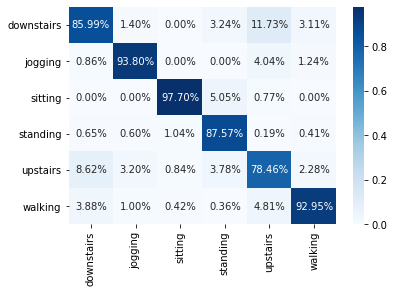

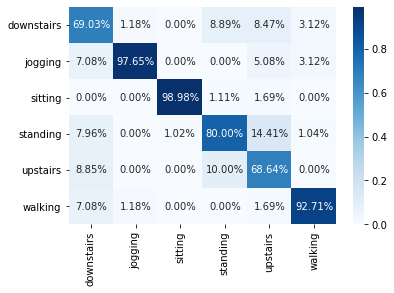

In [24]:
train_preds_lstm = lstm.predict(X_train)
test_preds_lstm = lstm.predict(X_test)
confusion_mat_train_lstm = metrics.confusion_matrix(np.argmax(y_train,1),train_preds_lstm)
confusion_mat_test_lstm = metrics.confusion_matrix(np.argmax(y_test,1),test_preds_lstm)

body_movements = ['downstairs','jogging','sitting','standing','upstairs','walking']
confusion_mat_train_lstm.columns = body_movements
confusion_mat_train_lstm.index = body_movements
confusion_mat_test_lstm.columns = body_movements
confusion_mat_test_lstm.index = body_movements

sns.heatmap(confusion_mat_train_lstm/np.sum(confusion_mat_train_lstm), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()
sns.heatmap(confusion_mat_test_lstm/np.sum(confusion_mat_test_lstm), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

In [25]:
lstm2 = LSTM(learning_rate = 2e-3,mom_coeff = 0.0,batch_size = 32,hidden_dim=128)
lstm2.fit(X_train,y_train,X_test,y_test,epochs = 15,optimizer='RMSprop')

Epoch : 1
[1/15] ------> Training :  Accuracy : 56.00000000000001
[1/15] ------> Training :  Loss     : 0.9163791485659012
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 47.16666666666667
[1/15] ------> Testing  :  Loss     : 1.279657978947347
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 64.5
[2/15] ------> Training :  Loss     : 1.1156187819404129
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 56.166666666666664
[2/15] ------> Testing  :  Loss     : 1.2116706737215388
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 63.96666666666667
[3/15] ------> Training :  Loss     : 0.8280062511452215
__________________________________________________________________

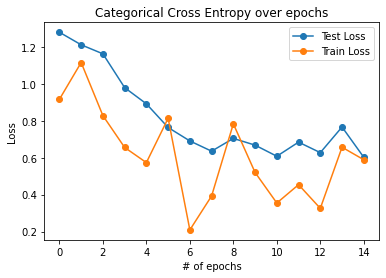

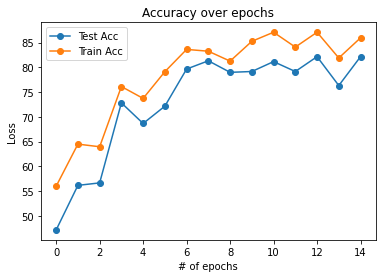

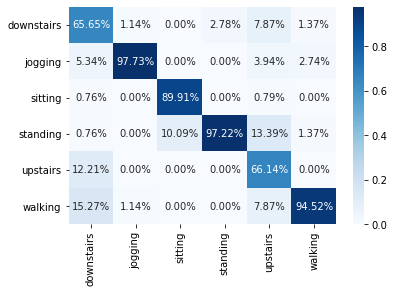

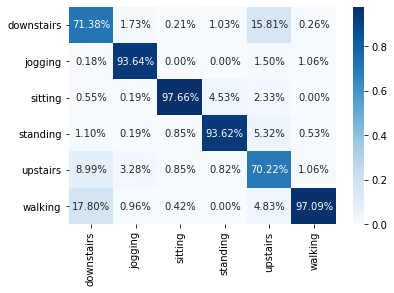

In [52]:
lstm2_history = lstm2.history()

In [57]:
lstm3 = LSTM(learning_rate = 3e-3,mom_coeff = 0.0,batch_size = 32,hidden_dim=128)
lstm3.fit(X_train,y_train,X_test,y_test,epochs = 15,optimizer='Adam')

Epoch : 1
[1/15] ------> Training :  Accuracy : 53.6
[1/15] ------> Training :  Loss     : 0.9317333062087536
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 54.333333333333336
[1/15] ------> Testing  :  Loss     : 1.248083204755446
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 67.33333333333333
[2/15] ------> Training :  Loss     : 1.1574743879155438
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 61.0
[2/15] ------> Testing  :  Loss     : 1.0263869028704813
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 75.2
[3/15] ------> Training :  Loss     : 0.6622835852458753
______________________________________________________________________________________

[3/1

In [60]:
lstm4 = LSTM(learning_rate = 1e-3,mom_coeff = 0.0,batch_size = 32,hidden_dim=128)
lstm4.fit(X_train,y_train,X_test,y_test,epochs = 15,optimizer='AdaGrad')

Epoch : 1
[1/15] ------> Training :  Accuracy : 44.766666666666666
[1/15] ------> Training :  Loss     : 1.358941409793942
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 29.333333333333332
[1/15] ------> Testing  :  Loss     : 1.4632356004624183
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 50.8
[2/15] ------> Training :  Loss     : 1.4202498595138642
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 41.333333333333336
[2/15] ------> Testing  :  Loss     : 1.3755920572455127
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 54.800000000000004
[3/15] ------> Training :  Loss     : 1.288135398664544
________________________________________________________________

In [83]:
lstm5 = LSTM(learning_rate = 1e-3,mom_coeff = 0.0,batch_size = 32,hidden_dim=128)
lstm5.fit(X_train,y_train,X_test,y_test,epochs = 15,optimizer='VanillaAdam')

Epoch : 1
[1/15] ------> Training :  Accuracy : 61.633333333333326
[1/15] ------> Training :  Loss     : 0.9231993305866116
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 57.333333333333336
[1/15] ------> Testing  :  Loss     : 1.212219304449006
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 70.56666666666666
[2/15] ------> Training :  Loss     : 0.9878333128432041
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 64.0
[2/15] ------> Testing  :  Loss     : 1.0658556453269463
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 74.76666666666667
[3/15] ------> Training :  Loss     : 0.6857803242534914
_________________________________________________________________

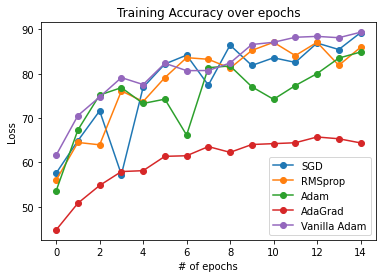

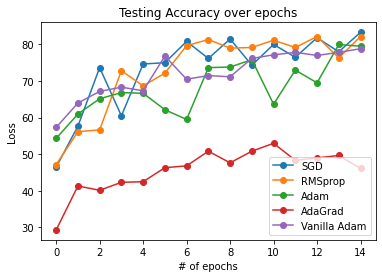

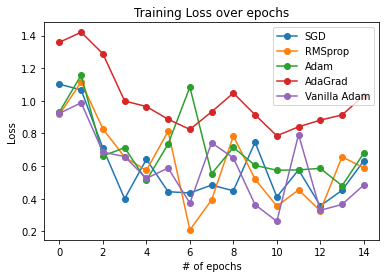

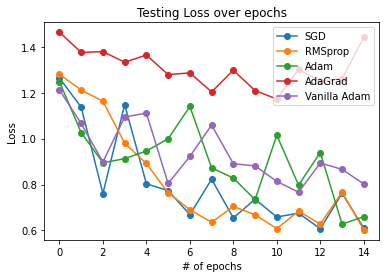

In [87]:
lstm3_history = lstm3.history()
lstm4_history = lstm4.history()
lstm5_history = lstm5.history()
plt.figure()
plt.plot(lstm_history['TrainAcc'],'-o')
plt.plot(lstm2_history['TrainAcc'],'-o')
plt.plot(lstm3_history['TrainAcc'],'-o')
plt.plot(lstm4_history['TrainAcc'],'-o')
plt.plot(lstm5_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['SGD','RMSprop','Adam','AdaGrad','Vanilla Adam'])
plt.show()

plt.figure()
plt.plot(lstm_history['TestAcc'],'-o')
plt.plot(lstm2_history['TestAcc'],'-o')
plt.plot(lstm3_history['TestAcc'],'-o')
plt.plot(lstm4_history['TestAcc'],'-o')
plt.plot(lstm5_history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['SGD','RMSprop','Adam','AdaGrad','Vanilla Adam'])
plt.show()

plt.figure()
plt.plot(lstm_history['TrainLoss'],'-o')
plt.plot(lstm2_history['TrainLoss'],'-o')
plt.plot(lstm3_history['TrainLoss'],'-o')
plt.plot(lstm4_history['TrainLoss'],'-o')
plt.plot(lstm5_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend(['SGD','RMSprop','Adam','AdaGrad','Vanilla Adam'])
plt.show()

plt.figure()
plt.plot(lstm_history['TestLoss'],'-o')
plt.plot(lstm2_history['TestLoss'],'-o')
plt.plot(lstm3_history['TestLoss'],'-o')
plt.plot(lstm4_history['TestLoss'],'-o')
plt.plot(lstm5_history['TestLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.legend(['SGD','RMSprop','Adam','AdaGrad','Vanilla Adam'])
plt.show()

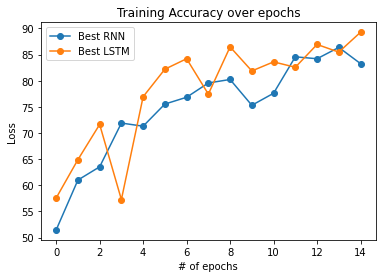

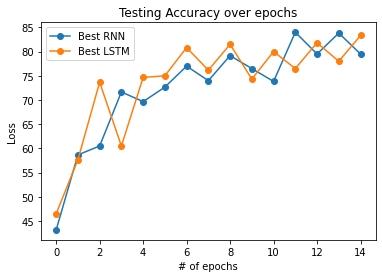

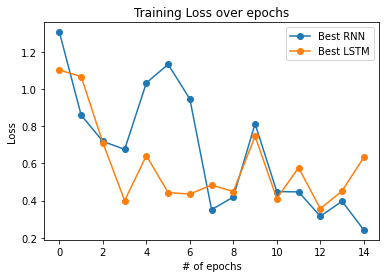

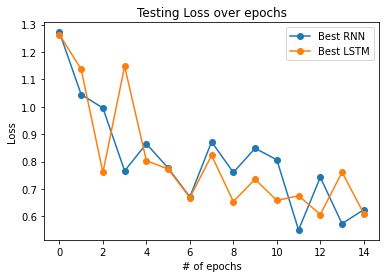

In [85]:
three_layer_rnn_v2_history = three_layer_rnn_v2.history()
plt.figure()
plt.plot(three_layer_rnn_v2_history['TrainAcc'],'-o')
plt.plot(lstm_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['Best RNN','Best LSTM'])
plt.show()


plt.figure()
plt.plot(three_layer_rnn_v2_history['TestAcc'],'-o')
plt.plot(lstm_history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['Best RNN','Best LSTM'])
plt.show()

plt.figure()
plt.plot(three_layer_rnn_v2_history['TrainLoss'],'-o')
plt.plot(lstm_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend(['Best RNN','Best LSTM'])
plt.show()


plt.figure()
plt.plot(three_layer_rnn_v2_history['TestLoss'],'-o')
plt.plot(lstm_history['TestLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.legend(['Best RNN','Best LSTM'])
plt.show()

In [ ]:
train_preds_lstm = lstm3.predict(X_train)
test_preds_lstm = lstm3.predict(X_test)
confusion_mat_train_lstm = metrics.confusion_matrix(np.argmax(y_train,1),train_preds_lstm)
confusion_mat_test_lstm = metrics.confusion_matrix(np.argmax(y_test,1),test_preds_lstm)

body_movements = ['downstairs','jogging','sitting','standing','upstairs','walking']
confusion_mat_train_lstm.columns = body_movements
confusion_mat_train_lstm.index = body_movements
confusion_mat_test_lstm.columns = body_movements
confusion_mat_test_lstm.index = body_movements

sns.heatmap(confusion_mat_train_lstm/np.sum(confusion_mat_train_lstm), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()
sns.heatmap(confusion_mat_test_lstm/np.sum(confusion_mat_test_lstm), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

In [36]:
class Multi_Layer_LSTM(object):
    """

    Long-Short Term Memory Recurrent neural network, encapsulates all necessary logic for training, then built the hyperparameters and architecture of the network.
    """

    def __init__(self,input_dim = 3,hidden_dim_1 = 128,hidden_dim_2 =64,output_class = 6,seq_len = 150,batch_size = 30,learning_rate = 1e-1,mom_coeff = 0.85):
        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(150)
        self.input_dim = input_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2

        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

        self.input_stack_dim = self.input_dim + self.hidden_dim_1
        
        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim1 = Xavier(self.input_dim,self.hidden_dim_1)
        self.W_f = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim_1))
        self.B_f = np.random.uniform(-lim1,lim1,(1,self.hidden_dim_1))

        self.W_i = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim_1))
        self.B_i = np.random.uniform(-lim1,lim1,(1,self.hidden_dim_1))

        self.W_c = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim_1))
        self.B_c = np.random.uniform(-lim1,lim1,(1,self.hidden_dim_1))

        self.W_o = np.random.uniform(-lim1,lim1,(self.input_stack_dim,self.hidden_dim_1))
        self.B_o = np.random.uniform(-lim1,lim1,(1,self.hidden_dim_1))
        
        lim2 = Xavier(self.hidden_dim_1,self.hidden_dim_2)
        self.W_hid = np.random.uniform(-lim2,lim2,(self.hidden_dim_1,self.hidden_dim_2))
        self.B_hid = np.random.uniform(-lim2,lim2,(1,self.hidden_dim_2))

        lim3 = Xavier(self.hidden_dim_2,self.output_class)
        self.W = np.random.uniform(-lim3,lim3,(self.hidden_dim_2,self.output_class))
        self.B = np.random.uniform(-lim3,lim3,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # To keep previous updates in momentum :
        self.previous_updates = [0] * 13
        
        # For AdaGrad:
        self.cache = [0] * 13     
        self.cache_rmsprop = [0] * 13
        self.m = [0] * 13
        self.v = [0] * 13
        self.t = 1

    def cell_forward(self,X,h_prev,C_prev):
        """

        Takes input, previous hidden state and previous cell state, compute:
        --- Forget gate + Input gate + New candidate input + New cell state + 
            output gate + hidden state. Then, classify by softmax.
        """
        #print(X.shape,h_prev.shape)
        # Stacking previous hidden state vector with inputs:
        stack = np.column_stack([X,h_prev])

        # Forget gate:
        forget_gate = activations.sigmoid(np.dot(stack,self.W_f) + self.B_f)
       
        # İnput gate:
        input_gate = activations.sigmoid(np.dot(stack,self.W_i) + self.B_i)

        # New candidate:
        cell_bar = np.tanh(np.dot(stack,self.W_c) + self.B_c)

        # New Cell state:
        cell_state = forget_gate * C_prev + input_gate * cell_bar

        # Output fate:
        output_gate = activations.sigmoid(np.dot(stack,self.W_o) + self.B_o)

        # Hidden state:
        hidden_state = output_gate * np.tanh(cell_state)

        # Classifiers (Softmax) :
        dense_hid = np.dot(hidden_state,self.W_hid) + self.B_hid
        act = activations.ReLU(dense_hid)

        dense = np.dot(act,self.W) + self.B
        probs = activations.softmax(dense)

        return (stack,forget_gate,input_gate,cell_bar,cell_state,output_gate,hidden_state,dense,probs,dense_hid,act)

        

    def forward(self,X,h_prev,C_prev):
        x_s,z_s,f_s,i_s = {},{},{},{}
        C_bar_s,C_s,o_s,h_s = {},{},{},{}
        v_s,y_s,v_1s,y_1s = {},{},{},{}


        h_s[-1] = np.copy(h_prev)
        C_s[-1] = np.copy(C_prev)

        for t in range(self.seq_len):
            x_s[t] = X[:,t,:]
            z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t],v_s[t], y_s[t],v_1s[t],y_1s[t] = self.cell_forward(x_s[t],h_s[t-1],C_s[t-1])

        return (z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s,v_s, y_s,v_1s,y_1s)
    
    def BPTT(self,outs,Y):

        z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s,v_s, y_s,v_1s,y_1s = outs

        dW_f, dW_i,dW_c, dW_o,dW,dW_hid = np.zeros_like(self.W_f), np.zeros_like(self.W_i), np.zeros_like(self.W_c),np.zeros_like(self.W_o),np.zeros_like(self.W),np.zeros_like(self.W_hid)

        dB_f, dB_i,dB_c,dB_o,dB,dB_hid  = np.zeros_like(self.B_f), np.zeros_like(self.B_i),np.zeros_like(self.B_c),np.zeros_like(self.B_o),np.zeros_like(self.B),np.zeros_like(self.B_hid)

        dh_next = np.zeros_like(h_s[0]) 
        dC_next = np.zeros_like(C_s[0])   

        # w.r.t. softmax input
        ddense = np.copy(y_s[149])
        ddense[np.arange(len(Y)),np.argmax(Y,1)] -= 1
        #ddense[np.argmax(Y,1)] -=1
        #ddense = y_s[149] - Y
        # Softmax classifier's :
        dW = np.dot(v_1s[149].T,ddense)
        dB = np.sum(ddense,axis = 0, keepdims = True)

        ddense_hid = np.dot(ddense,self.W.T) * activations.dReLU(v_1s[149])
        dW_hid = np.dot(h_s[149].T,ddense_hid)
        dB_hid = np.sum(ddense_hid,axis = 0, keepdims = True)


        # Backprop through time:
        for t in reversed(range(1,self.seq_len)):           
            
            # Just equating more meaningful names
            stack,forget_gate,input_gate,cell_bar,cell_state,output_gate,hidden_state,dense,probs = z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t],v_s[t], y_s[t]
            C_prev = C_s[t-1]
            
            # w.r.t. softmax input
            #ddense = np.copy(probs)
            #ddense[np.arange(len(Y)),np.argmax(Y,1)] -= 1
            #ddense[np.arange(len(Y)),np.argmax(Y,1)] -=1
            # Softmax classifier's :
            #dW += np.dot(hidden_state.T,ddense)
            #dB += np.sum(ddense,axis = 0, keepdims = True)

            # Output gate :
            dh = np.dot(ddense_hid,self.W_hid.T) + dh_next            
            do = dh * np.tanh(cell_state)
            do = do * dsigmoid(output_gate)
            dW_o += np.dot(stack.T,do)
            dB_o += np.sum(do,axis = 0, keepdims = True)

            # Cell state:
            dC = np.copy(dC_next)
            dC += dh * output_gate * activations.dtanh(cell_state)
            dC_bar = dC * input_gate
            dC_bar = dC_bar * dtanh(cell_bar) 
            dW_c += np.dot(stack.T,dC_bar)
            dB_c += np.sum(dC_bar,axis = 0, keepdims = True)
            
            # Input gate:
            di = dC * cell_bar
            di = dsigmoid(input_gate) * di
            dW_i += np.dot(stack.T,di)
            dB_i += np.sum(di,axis = 0,keepdims = True)

            # Forget gate:
            df = dC * C_prev
            df = df * dsigmoid(forget_gate) 
            dW_f += np.dot(stack.T,df)
            dB_f += np.sum(df,axis = 0, keepdims = True)

            dz = np.dot(df,self.W_f.T) + np.dot(di,self.W_i.T) + np.dot(dC_bar,self.W_c.T) + np.dot(do,self.W_o.T)

            dh_next = dz[:,-self.hidden_dim_1:]
            dC_next = forget_gate * dC
        
        # List of gradients :
        grads = [dW,dB,dW_hid,dB_hid,dW_o,dB_o,dW_c,dB_c,dW_i,dB_i,dW_f,dB_f]

        # Clipping gradients anyway
        for grad in grads:
            np.clip(grad, -15, 15, out = grad)

        return h_s[self.seq_len - 1],C_s[self.seq_len -1 ],grads
    


    def fit(self,X,Y,X_val,y_val,epochs = 50 ,optimizer = 'SGD',verbose = True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)           
            h_prev,C_prev = np.zeros((self.batch_size,self.hidden_dim_1)),np.zeros((self.batch_size,self.hidden_dim_1))
            for i in range(round(X.shape[0]/self.batch_size) - 1): 
               
                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size                
                index = perm[batch_start:batch_finish]
                
                # Feeding random indexes:
                X_feed = X[index]    
                y_feed = Y[index]
               
                # Forward + BPTT + SGD:
                cache_train = self.forward(X_feed,h_prev,C_prev)
                h,c,grads = self.BPTT(cache_train,y_feed)

                if optimizer == 'SGD':                                                           
                  self.SGD(grads)

                elif optimizer == 'AdaGrad' :
                  self.AdaGrad(grads)

                elif optimizer == 'RMSprop':
                  self.RMSprop(grads)
                
                elif optimizer == 'VanillaAdam':
                  self.VanillaAdam(grads)
                else:
                  self.Adam(grads)

                # Hidden state -------> Previous hidden state
                # Cell state ---------> Previous cell state
                h_prev,C_prev = h,c

            # Training metrics calculations:
            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[8][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)

            # Validation metrics calculations:
            test_prevs = np.zeros((X_val.shape[0],self.hidden_dim_1))
            _,__,___,____,_____,______,_______,________,probs_test,a,b = self.forward(X_val,test_prevs,test_prevs)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)
      
    
    def params(self):
        """
        Return all weights/biases in sequential order starting from end in list form.

        """        
        return [self.W,self.B,self.W_hid,self.B_hid,self.W_o,self.B_o,self.W_c,self.B_c,self.W_i,self.B_i,self.W_f,self.B_f]


    def SGD(self,grads):
      """

      Stochastic gradient descent with momentum on mini-batches.
      """
      prevs = []
     
      for param,grad,prev_update in zip(self.params(),grads,self.previous_updates):            
          delta = self.learning_rate * grad - self.mom_coeff * prev_update
          param -= delta 
          prevs.append(delta)
     
         

      self.previous_updates = prevs     

      self.learning_rate *= 0.99999   

    
    def AdaGrad(self,grads):
      """
      AdaGrad adaptive optimization algorithm.
      """         
      i = 0
      for param,grad in zip(self.params(),grads):
        self.cache[i] += grad **2
        param += -self.learning_rate * grad / (np.sqrt(self.cache[i]) + 1e-6)
        i += 1


    def RMSprop(self,grads,decay_rate = 0.9):
      """

      RMSprop adaptive optimization algorithm
      """


      i = 0
      for param,grad in zip(self.params(),grads):
        self.cache_rmsprop[i] = decay_rate * self.cache_rmsprop[i] + (1-decay_rate) * grad **2
        param += - self.learning_rate * grad / (np.sqrt(self.cache_rmsprop[i])+ 1e-6)
        i += 1


    def VanillaAdam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """
        Adam optimizer, but bias correction is not implemented
        """
        i = 0

        for param,grad  in zip(self.params(),grads):

          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2  
          param += -self.learning_rate * self.m[i] / (np.sqrt(self.v[i]) + 1e-8)
          i += 1


    def Adam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """

        Adam optimizer, bias correction is implemented.
        """
      
        i = 0

        for param,grad  in zip(self.params(),grads):
          
          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2
          m_corrected = self.m[i] / (1-beta1**self.t)
          v_corrected = self.v[i] / (1-beta2**self.t)
          param += -self.learning_rate * m_corrected / (np.sqrt(v_corrected) + 1e-8)
          i += 1
          
        self.t +=1
    
    
    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N
    
    def predict(self,X):
        """
        Return predictions, (not one hot encoded format)
        """

        # Give zeros to hidden/cell states:
        pasts = np.zeros((X.shape[0],self.hidden_dim_1))
        _,__,___,____,_____,______,_______,_______,probs,a,b = self.forward(X,pasts,pasts)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}      

In [38]:
mutl_layer_lstm = Multi_Layer_LSTM(learning_rate=1e-3,batch_size=32,hidden_dim_1 = 128,hidden_dim_2=64,mom_coeff=0.0)
mutl_layer_lstm.fit(X_train,y_train,X_test,y_test,epochs=15,optimizer='Adam')

Epoch : 1
[1/15] ------> Training :  Accuracy : 49.9
[1/15] ------> Training :  Loss     : 1.2456796226499867
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 40.0
[1/15] ------> Testing  :  Loss     : 1.4144956937913982
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 56.63333333333333
[2/15] ------> Training :  Loss     : 1.1011425978659983
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 53.0
[2/15] ------> Testing  :  Loss     : 1.2492632736432905
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 64.60000000000001
[3/15] ------> Training :  Loss     : 0.9700087666643786
______________________________________________________________________________________

[3/1

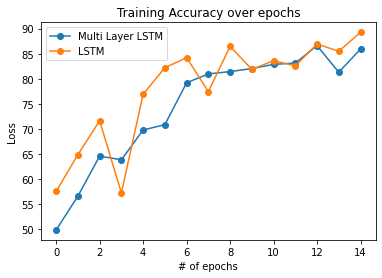

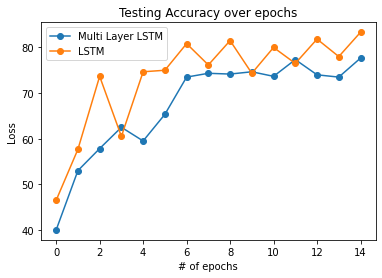

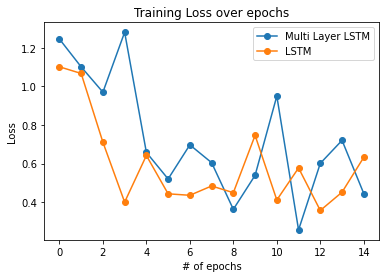

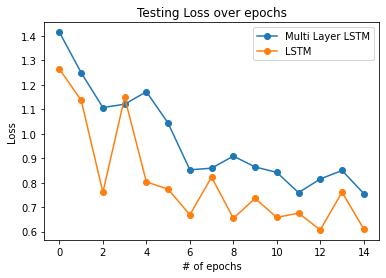

In [39]:
mutl_layer_lstm_history = mutl_layer_lstm.history()
plt.figure()
plt.plot(mutl_layer_lstm_history['TrainAcc'],'-o')
plt.plot(lstm_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['Multi Layer LSTM','LSTM'])
plt.show()


plt.figure()
plt.plot(mutl_layer_lstm_history['TestAcc'],'-o')
plt.plot(lstm_history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['Multi Layer LSTM','LSTM'])
plt.show()

plt.figure()
plt.plot(mutl_layer_lstm_history['TrainLoss'],'-o')
plt.plot(lstm_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend(['Multi Layer LSTM','LSTM'])
plt.show()


plt.figure()
plt.plot(mutl_layer_lstm_history['TestLoss'],'-o')
plt.plot(lstm_history['TestLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.legend(['Multi Layer LSTM','LSTM'])
plt.show()

In [84]:
mutl_layer_lstm.fit(X_train,y_train,X_test,y_test,epochs=15,optimizer = 'Vanilla')

Epoch : 1
[1/15] ------> Training :  Accuracy : 81.89999999999999
[1/15] ------> Training :  Loss     : 0.47346464702328395
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 76.5
[1/15] ------> Testing  :  Loss     : 0.7271558789859983
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 83.76666666666667
[2/15] ------> Training :  Loss     : 0.3739539458975825
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 77.0
[2/15] ------> Testing  :  Loss     : 0.7600886847949024
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 84.89999999999999
[3/15] ------> Training :  Loss     : 0.7199125538921682
______________________________________________________________________________

In [88]:
mutl_layer_lstm_history = mutl_layer_lstm.history()

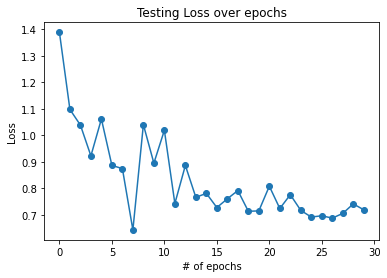

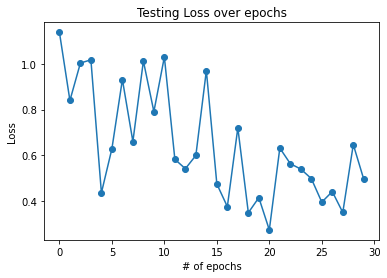

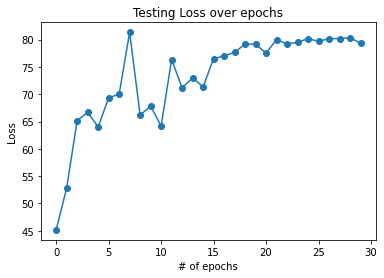

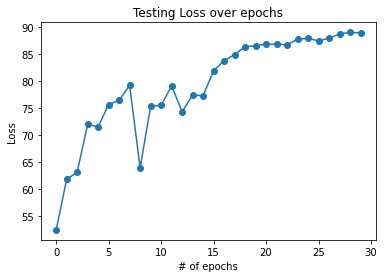

In [93]:
plt.figure()
plt.plot(mutl_layer_lstm_history['TestLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.show()

plt.figure()
plt.plot(mutl_layer_lstm_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.show()


plt.figure()
plt.plot(mutl_layer_lstm_history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.show()


plt.figure()
plt.plot(mutl_layer_lstm_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.show()

In [40]:
class GRU(object):
    """

    Gater recurrent unit, encapsulates all necessary logic for training, then built the hyperparameters and architecture of the network.
    """

    def __init__(self,input_dim = 3,hidden_dim = 128,output_class = 6,seq_len = 150,batch_size = 32,learning_rate = 1e-1,mom_coeff = 0.85):
        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(32)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

       
        
        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim1 = Xavier(self.input_dim,self.hidden_dim)
        lim1_hid = Xavier(self.hidden_dim,self.hidden_dim)
        self.W_z = np.random.uniform(-lim1,lim1,(self.input_dim,self.hidden_dim))
        self.U_z = np.random.uniform(-lim1_hid,lim1_hid,(self.hidden_dim,self.hidden_dim))
        self.B_z = np.random.uniform(-lim1,lim1,(1,self.hidden_dim))

        self.W_r = np.random.uniform(-lim1,lim1,(self.input_dim,self.hidden_dim))
        self.U_r = np.random.uniform(-lim1_hid,lim1_hid,(self.hidden_dim,self.hidden_dim))
        self.B_r = np.random.uniform(-lim1,lim1,(1,self.hidden_dim))

        self.W_h = np.random.uniform(-lim1,lim1,(self.input_dim,self.hidden_dim))
        self.U_h = np.random.uniform(-lim1_hid,lim1_hid,(self.hidden_dim,self.hidden_dim))
        self.B_h = np.random.uniform(-lim1,lim1,(1,self.hidden_dim))

        
        lim2 = Xavier(self.hidden_dim,self.output_class)
        self.W = np.random.uniform(-lim2,lim2,(self.hidden_dim,self.output_class))
        self.B = np.random.uniform(-lim2,lim2,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # To keep previous updates in momentum :
        self.previous_updates = [0] * 10
        
        # For AdaGrad:
        self.cache = [0] * 11   
        self.cache_rmsprop = [0] * 11
        self.m = [0] * 11
        self.v = [0] * 11
        self.t = 1

    def cell_forward(self,X,h_prev):
        """

        Takes input, previous hidden state and previous cell state, compute:
        --- Forget gate + Input gate + New candidate input + New cell state + 
            output gate + hidden state. Then, classify by softmax.
        """
                      

        # Update gate:
        update_gate = activations.sigmoid(np.dot(X,self.W_z) + np.dot(h_prev,self.U_z) + self.B_z)
       
        # Reset gate:
        reset_gate = activations.sigmoid(np.dot(X,self.W_r) + np.dot(h_prev,self.U_r) + self.B_r)

        # Current memory content:
        h_hat = np.tanh(np.dot(X,self.W_h) + np.dot(np.multiply(reset_gate,h_prev),self.U_h) + self.B_h)

        # Hidden state:
        hidden_state = np.multiply(update_gate,h_prev) + np.multiply((1-update_gate),h_hat)


        # Classifiers (Softmax) :
        dense = np.dot(hidden_state,self.W) + self.B
        probs = activations.softmax(dense)

        return (update_gate,reset_gate,h_hat,hidden_state,dense,probs)

        

    def forward(self,X,h_prev):
        x_s,z_s,r_s,h_hat = {},{},{},{}
        h_s = {}
        y_s,p_s = {},{}        

        h_s[-1] = np.copy(h_prev)
        

        for t in range(self.seq_len):
            x_s[t] = X[:,t,:]
            z_s[t], r_s[t], h_hat[t], h_s[t], y_s[t], p_s[t] = self.cell_forward(x_s[t],h_s[t-1])

        return (x_s,z_s, r_s, h_hat, h_s, y_s, p_s)
    
    def BPTT(self,outs,Y):

        x_s,z_s, r_s, h_hat, h_s, y_s, p_s = outs

        dW_z, dW_r,dW_h, dW = np.zeros_like(self.W_z), np.zeros_like(self.W_r), np.zeros_like(self.W_h),np.zeros_like(self.W)

        dU_z, dU_r,dU_h, = np.zeros_like(self.U_z), np.zeros_like(self.U_r), np.zeros_like(self.U_h)


        dB_z, dB_r,dB_h,dB = np.zeros_like(self.B_z), np.zeros_like(self.B_r),np.zeros_like(self.B_h),np.zeros_like(self.B)

        dh_next = np.zeros_like(h_s[0]) 
           

        # w.r.t. softmax input
        ddense = np.copy(p_s[149])
        ddense[np.arange(len(Y)),np.argmax(Y,1)] -= 1
        #ddense[np.argmax(Y,1)] -=1
        #ddense = y_s[149] - Y
        # Softmax classifier's :
        dW = np.dot(h_s[149].T,ddense)
        dB = np.sum(ddense,axis = 0, keepdims = True)

        # Backprop through time:
        for t in reversed(range(1,self.seq_len)):           
                        
            # w.r.t. softmax input
            #ddense = np.copy(probs)
            #ddense[np.arange(len(Y)),np.argmax(Y,1)] -= 1
            #ddense[np.arange(len(Y)),np.argmax(Y,1)] -=1
            # Softmax classifier's :
            #dW += np.dot(hidden_state.T,ddense)
            #dB += np.sum(ddense,axis = 0, keepdims = True)


            # Curernt memort state :
            dh = np.dot(ddense,self.W.T) + dh_next            
            dh_hat = dh * (1-z_s[t])
            dh_hat = dh_hat * dtanh(h_hat[t])
            dW_h += np.dot(x_s[t].T,dh_hat)
            dU_h += np.dot((r_s[t] * h_s[t-1]).T,dh_hat)
            dB_h += np.sum(dh_hat,axis = 0, keepdims = True)

            # Reset gate:
            dr_1 = np.dot(dh_hat,self.U_h.T)
            dr = dr_1  * h_s[t-1]
            dr = dr * dsigmoid(r_s[t])
            dW_r += np.dot(x_s[t].T,dr)
            dU_r += np.dot(h_s[t-1].T,dr)
            dB_r += np.sum(dr,axis = 0, keepdims = True)

            # Forget gate:
            dz = dh * (h_s[t-1] - h_hat[t])
            dz = dz * dsigmoid(z_s[t])
            dW_z += np.dot(x_s[t].T,dz)
            dU_z += np.dot(h_s[t-1].T,dz)
            dB_z += np.sum(dz,axis = 0, keepdims = True)


            # Nexts:
            dh_next = np.dot(dz,self.U_z.T) + (dh * z_s[t]) + (dr_1 * r_s[t]) + np.dot(dr,self.U_r.T)


        # List of gradients :
        grads = [dW,dB,dW_z,dU_z,dB_z,dW_r,dU_r,dB_r,dW_h,dU_h,dB_h]

        # Clipping gradients anyway
        for grad in grads:
            np.clip(grad, -15, 15, out = grad)

        return h_s[self.seq_len - 1],grads
    


    def fit(self,X,Y,X_val,y_val,epochs = 50 ,optimizer = 'SGD',verbose = True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)           
            h_prev = np.zeros((self.batch_size,self.hidden_dim))
            for i in range(round(X.shape[0]/self.batch_size) - 1): 
               
                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size                
                index = perm[batch_start:batch_finish]
                
                # Feeding random indexes:
                X_feed = X[index]    
                y_feed = Y[index]
               
                # Forward + BPTT + SGD:
                cache_train = self.forward(X_feed,h_prev)
                h,grads = self.BPTT(cache_train,y_feed)

                if optimizer == 'SGD':                                                                
                  self.SGD(grads)

                elif optimizer == 'AdaGrad' :
                  self.AdaGrad(grads)

                elif optimizer == 'RMSprop':
                  self.RMSprop(grads)
                
                elif optimizer == 'VanillaAdam':
                  self.VanillaAdam(grads)
                else:
                  self.Adam(grads)

                # Hidden state -------> Previous hidden state
                h_prev= h

            # Training metrics calculations:
            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[6][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)

            # Validation metrics calculations:
            test_prevs = np.zeros((X_val.shape[0],self.hidden_dim))
            _,__,___,____,_____,______,probs_test = self.forward(X_val,test_prevs)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)
      
    
    def params(self):
        """
        Return all weights/biases in sequential order starting from end in list form.

        """        
        return [self.W,self.B,self.W_z,self.U_z,self.B_z,self.W_r,self.U_r,self.B_r,self.W_h,self.U_h,self.B_h]

    def SGD(self,grads):
      """

      Stochastic gradient descent with momentum on mini-batches.
      """
      prevs = []
      for param,grad,prev_update in zip(self.params(),grads,self.previous_updates):            
          delta = self.learning_rate * grad - self.mom_coeff * prev_update
          param -= delta 
          prevs.append(delta)

      self.previous_updates = prevs       

      self.learning_rate *= 0.99999   

    
    def AdaGrad(self,grads):
      """
      AdaGrad adaptive optimization algorithm.
      """         

      i = 0
      for param,grad in zip(self.params(),grads):

        self.cache[i] += grad **2
        param += -self.learning_rate * grad / (np.sqrt(self.cache[i]) + 1e-6)

        i += 1


    def RMSprop(self,grads,decay_rate = 0.9):
      """

      RMSprop adaptive optimization algorithm
      """


      i = 0
      for param,grad in zip(self.params(),grads):
        self.cache_rmsprop[i] = decay_rate * self.cache_rmsprop[i] + (1-decay_rate) * grad **2
        param += - self.learning_rate * grad / (np.sqrt(self.cache_rmsprop[i])+ 1e-6)
        i += 1


    def VanillaAdam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """
        Adam optimizer, but bias correction is not implemented
        """
        i = 0

        for param,grad  in zip(self.params(),grads):

          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2  
          param += -self.learning_rate * self.m[i] / (np.sqrt(self.v[i]) + 1e-8)
          i += 1


    def Adam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """

        Adam optimizer, bias correction is implemented.
        """
      
        i = 0

        for param,grad  in zip(self.params(),grads):
          
          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2
          m_corrected = self.m[i] / (1-beta1**self.t)
          v_corrected = self.v[i] / (1-beta2**self.t)
          param += -self.learning_rate * m_corrected / (np.sqrt(v_corrected) + 1e-8)
          i += 1
          
        self.t +=1
    
    
    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N
    
    def predict(self,X):
        """
        Return predictions, (not one hot encoded format)
        """

        # Give zeros to hidden/cell states:
        pasts = np.zeros((X.shape[0],self.hidden_dim))
        _,__,___,____,_____,______,probs = self.forward(X,pasts)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}      

In [41]:
gru = GRU(hidden_dim=128,learning_rate=1e-3,batch_size=32,mom_coeff=0.0)

In [42]:
gru.fit(X_train,y_train,X_test,y_test,epochs = 15,optimizer = 'RMSprop')

Epoch : 1
[1/15] ------> Training :  Accuracy : 61.5
[1/15] ------> Training :  Loss     : 1.0276452024873244
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 53.166666666666664
[1/15] ------> Testing  :  Loss     : 1.1624888600388588
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 63.96666666666667
[2/15] ------> Training :  Loss     : 1.0020584188663293
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 53.833333333333336
[2/15] ------> Testing  :  Loss     : 1.1723574031207136
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 71.1
[3/15] ------> Training :  Loss     : 1.0159057335643937
_____________________________________________________________________________

In [48]:
gru_history = gru.history()

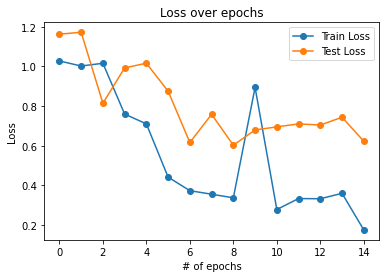

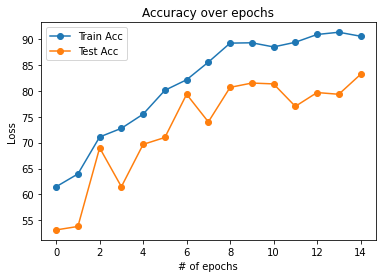

In [51]:
# For figure 97:

plt.figure()
plt.plot(gru_history['TrainLoss'],'-o')
plt.plot(gru_history['TestLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend(['Train Loss','Test Loss'])
plt.show()


plt.figure()
plt.plot(gru_history['TrainAcc'],'-o')
plt.plot(gru_history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Accuracy over epochs')
plt.legend(['Train Acc','Test Acc'])
plt.show()

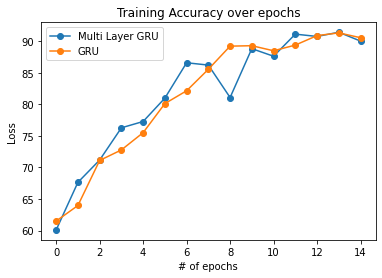

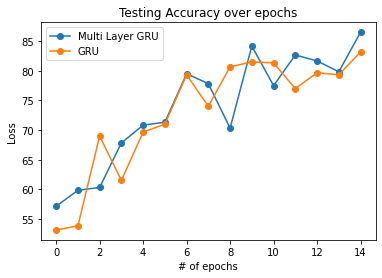

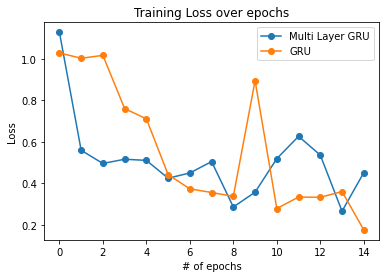

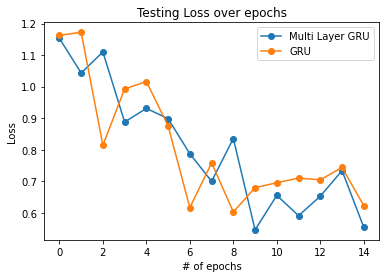

In [52]:
# For figure 98:
multi_layer_gru_history = multi_layer_gru.history()
plt.figure()
plt.plot(multi_layer_gru_history['TrainAcc'],'-o')
plt.plot(gru_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['Multi Layer GRU','GRU'])
plt.show()


plt.figure()
plt.plot(multi_layer_gru_history['TestAcc'],'-o')
plt.plot(gru_history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['Multi Layer GRU','GRU'])
plt.show()

plt.figure()
plt.plot(multi_layer_gru_history['TrainLoss'],'-o')
plt.plot(gru_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend(['Multi Layer GRU','GRU'])
plt.show()


plt.figure()
plt.plot(multi_layer_gru_history['TestLoss'],'-o')
plt.plot(gru_history['TestLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.legend(['Multi Layer GRU','GRU'])
plt.show()

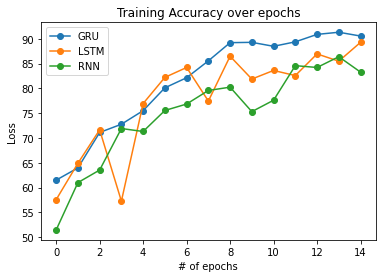

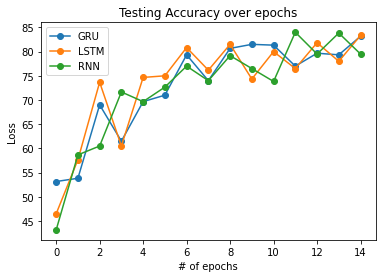

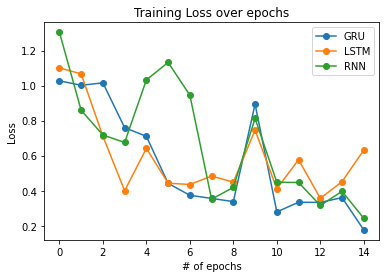

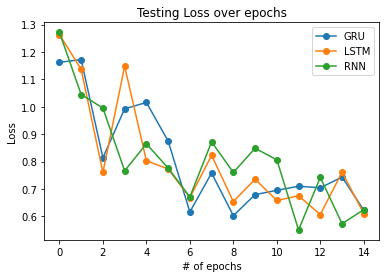

In [54]:
# For figure 99:
three_layer_rnn_history = three_layer_rnn.history()
plt.figure()
plt.plot(gru_history['TrainAcc'],'-o')
plt.plot(lstm_history['TrainAcc'],'-o')
plt.plot(three_layer_rnn_history['TrainAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Accuracy over epochs')
plt.legend(['GRU','LSTM','RNN'])
plt.show()


plt.figure()
plt.plot(gru_history['TestAcc'],'-o')
plt.plot(lstm_history['TestAcc'],'-o')
plt.plot(three_layer_rnn_history['TestAcc'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Accuracy over epochs')
plt.legend(['GRU','LSTM','RNN'])
plt.show()

plt.figure()
plt.plot(gru_history['TrainLoss'],'-o')
plt.plot(lstm_history['TrainLoss'],'-o')
plt.plot(three_layer_rnn_history['TrainLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend(['GRU','LSTM','RNN'])
plt.show()


plt.figure()
plt.plot(gru_history['TestLoss'],'-o')
plt.plot(lstm_history['TestLoss'],'-o')
plt.plot(three_layer_rnn_history['TestLoss'],'-o')
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.title('Testing Loss over epochs')
plt.legend(['GRU','LSTM','RNN'])
plt.show()

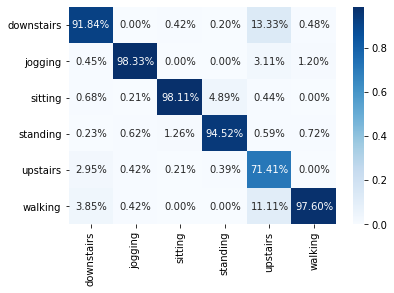

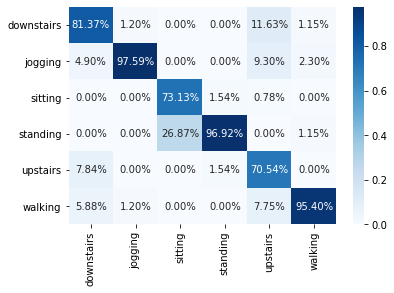

In [55]:
train_preds_gru = gru.predict(X_train)
test_preds_gru = gru.predict(X_test)
confusion_mat_train_gru = metrics.confusion_matrix(np.argmax(y_train,1),train_preds_gru)
confusion_mat_test_gru = metrics.confusion_matrix(np.argmax(y_test,1),test_preds_gru)

body_movements = ['downstairs','jogging','sitting','standing','upstairs','walking']
confusion_mat_train_gru.columns = body_movements
confusion_mat_train_gru.index = body_movements
confusion_mat_test_gru.columns = body_movements
confusion_mat_test_gru.index = body_movements

sns.heatmap(confusion_mat_train_gru/np.sum(confusion_mat_train_gru), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()
sns.heatmap(confusion_mat_test_gru/np.sum(confusion_mat_test_gru), annot=True, 
            fmt='.2%',cmap = 'Blues')
plt.show()

In [43]:
class Multi_layer_GRU(object):
    """

    Gater recurrent unit, encapsulates all necessary logic for training, then built the hyperparameters and architecture of the network.
    """

    def __init__(self,input_dim = 3,hidden_dim_1 = 128,hidden_dim_2 = 64,output_class = 6,seq_len = 150,batch_size = 32,learning_rate = 1e-1,mom_coeff = 0.85):
        """

        Initialization of weights/biases and other configurable parameters.
        
        """
        np.random.seed(150)
        self.input_dim = input_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2

        # Unfold case T = 150 :
        self.seq_len = seq_len
        self.output_class = output_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.mom_coeff = mom_coeff

       
        
        # Xavier uniform scaler :
        Xavier = lambda fan_in,fan_out : math.sqrt(6/(fan_in + fan_out))

        lim1 = Xavier(self.input_dim,self.hidden_dim_1)
        lim1_hid = Xavier(self.hidden_dim_1,self.hidden_dim_1)
        self.W_z = np.random.uniform(-lim1,lim1,(self.input_dim,self.hidden_dim_1))
        self.U_z = np.random.uniform(-lim1_hid,lim1_hid,(self.hidden_dim_1,self.hidden_dim_1))
        self.B_z = np.random.uniform(-lim1,lim1,(1,self.hidden_dim_1))

        self.W_r = np.random.uniform(-lim1,lim1,(self.input_dim,self.hidden_dim_1))
        self.U_r = np.random.uniform(-lim1_hid,lim1_hid,(self.hidden_dim_1,self.hidden_dim_1))
        self.B_r = np.random.uniform(-lim1,lim1,(1,self.hidden_dim_1))

        self.W_h = np.random.uniform(-lim1,lim1,(self.input_dim,self.hidden_dim_1))
        self.U_h = np.random.uniform(-lim1_hid,lim1_hid,(self.hidden_dim_1,self.hidden_dim_1))
        self.B_h = np.random.uniform(-lim1,lim1,(1,self.hidden_dim_1))

        lim2_hid = Xavier(self.hidden_dim_1,self.hidden_dim_2)
        self.W_hid = np.random.uniform(-lim2_hid,lim2_hid,(self.hidden_dim_1,self.hidden_dim_2))
        self.B_hid = np.random.uniform(-lim2_hid,lim2_hid,(1,self.hidden_dim_2))
        
        lim2 = Xavier(self.hidden_dim_2,self.output_class)
        self.W = np.random.uniform(-lim2,lim2,(self.hidden_dim_2,self.output_class))
        self.B = np.random.uniform(-lim2,lim2,(1,self.output_class))

        # To keep track loss and accuracy score :     
        self.train_loss,self.test_loss,self.train_acc,self.test_acc = [],[],[],[]
        
        # To keep previous updates in momentum :
        self.previous_updates = [0] * 13
        
        # For AdaGrad:
        self.cache = [0] * 13  
        self.cache_rmsprop = [0] * 13
        self.m = [0] * 13
        self.v = [0] * 13
        self.t = 1

    def cell_forward(self,X,h_prev):
        

        # Update gate:
        update_gate = activations.sigmoid(np.dot(X,self.W_z) + np.dot(h_prev,self.U_z) + self.B_z)
       
        # Reset gate:
        reset_gate = activations.sigmoid(np.dot(X,self.W_r) + np.dot(h_prev,self.U_r) + self.B_r)

        # Current memory content:
        h_hat = np.tanh(np.dot(X,self.W_h) + np.dot(np.multiply(reset_gate,h_prev),self.U_h) + self.B_h)

        # Hidden state:
        hidden_state = np.multiply(update_gate,h_prev) + np.multiply((1-update_gate),h_hat)

        # Hidden MLP:
        hid_dense = np.dot(hidden_state,self.W_hid) + self.B_hid
        relu = activations.ReLU(hid_dense)

        # Classifiers (Softmax) :
        dense = np.dot(relu,self.W) + self.B
        probs = activations.softmax(dense)

        return (update_gate,reset_gate,h_hat,hidden_state,hid_dense,relu,dense,probs)

        

    def forward(self,X,h_prev):
        x_s,z_s,r_s,h_hat = {},{},{},{}
        h_s = {}
        hd_s,relu_s = {},{}
        y_s,p_s = {},{}        

        h_s[-1] = np.copy(h_prev)
        

        for t in range(self.seq_len):
            x_s[t] = X[:,t,:]
            z_s[t], r_s[t], h_hat[t], h_s[t],hd_s[t],relu_s[t], y_s[t], p_s[t] = self.cell_forward(x_s[t],h_s[t-1])

        return (x_s,z_s, r_s, h_hat, h_s, hd_s,relu_s, y_s, p_s)
    
    def BPTT(self,outs,Y):

        x_s,z_s, r_s, h_hat, h_s, hd_s,relu_s, y_s, p_s = outs

        dW_z, dW_r,dW_h, dW = np.zeros_like(self.W_z), np.zeros_like(self.W_r), np.zeros_like(self.W_h),np.zeros_like(self.W)
        dW_hid = np.zeros_like(self.W_hid)
        dU_z, dU_r,dU_h = np.zeros_like(self.U_z), np.zeros_like(self.U_r), np.zeros_like(self.U_h)


        dB_z, dB_r,dB_h,dB = np.zeros_like(self.B_z), np.zeros_like(self.B_r),np.zeros_like(self.B_h),np.zeros_like(self.B)
        dB_hid = np.zeros_like(self.B_hid)
        dh_next = np.zeros_like(h_s[0]) 
           

        # w.r.t. softmax input
        ddense = np.copy(p_s[149])
        ddense[np.arange(len(Y)),np.argmax(Y,1)] -= 1
        #ddense[np.argmax(Y,1)] -=1
        #ddense = y_s[149] - Y
        # Softmax classifier's :
        dW = np.dot(relu_s[149].T,ddense)
        dB = np.sum(ddense,axis = 0, keepdims = True)

        ddense_hid = np.dot(ddense,self.W.T) * activations.dReLU(hd_s[149])
        dW_hid = np.dot(h_s[149].T,ddense_hid)
        dB_hid = np.sum(ddense_hid,axis = 0, keepdims = True)

   
        # Backprop through time:
        for t in reversed(range(1,self.seq_len)):           

            # Curernt memort state :
            dh = np.dot(ddense_hid,self.W_hid.T) + dh_next            
            dh_hat = dh * (1-z_s[t])
            dh_hat = dh_hat * dtanh(h_hat[t])
            dW_h += np.dot(x_s[t].T,dh_hat)
            dU_h += np.dot((r_s[t] * h_s[t-1]).T,dh_hat)
            dB_h += np.sum(dh_hat,axis = 0, keepdims = True)

            # Reset gate:
            dr_1 = np.dot(dh_hat,self.U_h.T)
            dr = dr_1  * h_s[t-1]
            dr = dr * dsigmoid(r_s[t])
            dW_r += np.dot(x_s[t].T,dr)
            dU_r += np.dot(h_s[t-1].T,dr)
            dB_r += np.sum(dr,axis = 0, keepdims = True)

            # Forget gate:
            dz = dh * (h_s[t-1] - h_hat[t])
            dz = dz * dsigmoid(z_s[t])
            dW_z += np.dot(x_s[t].T,dz)
            dU_z += np.dot(h_s[t-1].T,dz)
            dB_z += np.sum(dz,axis = 0, keepdims = True)


            # Nexts:
            dh_next = np.dot(dz,self.U_z.T) + (dh * z_s[t]) + (dr_1 * r_s[t]) + np.dot(dr,self.U_r.T)


        # List of gradients :
        grads = [dW,dB,dW_hid,dB_hid,dW_z,dU_z,dB_z,dW_r,dU_r,dB_r,dW_h,dU_h,dB_h]
              
        # Clipping gradients anyway
        for grad in grads:
            np.clip(grad, -15, 15, out = grad)

        return h_s[self.seq_len - 1],grads
    


    def fit(self,X,Y,X_val,y_val,epochs = 50 ,optimizer = 'SGD',verbose = True, crossVal = False):
        """
        Given the traning dataset,their labels and number of epochs
        fitting the model, and measure the performance
        by validating training dataset.
        """
                
        
        for epoch in range(epochs):
            
            print(f'Epoch : {epoch + 1}')

            perm = np.random.permutation(3000)

            # Equate 0 in every epoch:           
            h_prev = np.zeros((self.batch_size,self.hidden_dim_1))

            for i in range(round(X.shape[0]/self.batch_size) - 1): 
               
                batch_start  =  i * self.batch_size
                batch_finish = (i+1) * self.batch_size                
                index = perm[batch_start:batch_finish]
                
                # Feeding random indexes:
                X_feed = X[index]    
                y_feed = Y[index]
               
                # Forward + BPTT + Optimization:
                cache_train = self.forward(X_feed,h_prev)
                h,grads = self.BPTT(cache_train,y_feed)

                if optimizer == 'SGD':                                                                
                  self.SGD(grads)

                elif optimizer == 'AdaGrad' :
                  self.AdaGrad(grads)

                elif optimizer == 'RMSprop':
                  self.RMSprop(grads)
                
                elif optimizer == 'VanillaAdam':
                  self.VanillaAdam(grads)
                else:
                  self.Adam(grads)

                # Hidden state -------> Previous hidden state
                h_prev = h

            # Training metrics calculations:
            cross_loss_train = self.CategoricalCrossEntropy(y_feed,cache_train[8][149])
            predictions_train = self.predict(X)
            acc_train = metrics.accuracy(np.argmax(Y,1),predictions_train)

            # Validation metrics calculations:
            test_prevs = np.zeros((X_val.shape[0],self.hidden_dim_1))
            _,__,___,____,_____,______,_______,________,probs_test = self.forward(X_val,test_prevs)
            cross_loss_val = self.CategoricalCrossEntropy(y_val,probs_test[149])
            predictions_val = np.argmax(probs_test[149],1)
            acc_val = metrics.accuracy(np.argmax(y_val,1),predictions_val)

            if verbose:

                print(f"[{epoch + 1}/{epochs}] ------> Training :  Accuracy : {acc_train}")
                print(f"[{epoch + 1}/{epochs}] ------> Training :  Loss     : {cross_loss_train}")
                print('______________________________________________________________________________________\n')                         
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Accuracy : {acc_val}")                                        
                print(f"[{epoch + 1}/{epochs}] ------> Testing  :  Loss     : {cross_loss_val}")
                print('______________________________________________________________________________________\n')
                
            self.train_loss.append(cross_loss_train)              
            self.test_loss.append(cross_loss_val) 
            self.train_acc.append(acc_train)              
            self.test_acc.append(acc_val)
      
    
    def params(self):
        """
        Return all weights/biases in sequential order starting from end in list form.

        """        
        return [self.W,self.B,self.W_hid,self.B_hid,self.W_z,self.U_z,self.B_z,self.W_r,self.U_r,self.B_r,self.W_h,self.U_h,self.B_h]

    def SGD(self,grads):
      """

      Stochastic gradient descent with momentum on mini-batches.
      """
      prevs = []
      
      for param,grad,prev_update in zip(self.params(),grads,self.previous_updates): 
                     
          delta = self.learning_rate * grad + self.mom_coeff * prev_update
          param -= delta 
          prevs.append(delta)
        

      self.previous_updates = prevs     
      self.learning_rate *= 0.99999   

    
    def AdaGrad(self,grads):
      """
      AdaGrad adaptive optimization algorithm.
      """      

      i = 0
      for param,grad in zip(self.params(),grads):

        self.cache[i] += grad **2
        param += -self.learning_rate * grad / (np.sqrt(self.cache[i]) + 1e-6)

        i += 1


    def RMSprop(self,grads,decay_rate = 0.9):
      """
      RMSprop adaptive optimization algorithm
      """
      i = 0
      for param,grad in zip(self.params(),grads):
        self.cache_rmsprop[i] = decay_rate * self.cache_rmsprop[i] + (1-decay_rate) * grad **2
        param += - self.learning_rate * grad / (np.sqrt(self.cache_rmsprop[i])+ 1e-6)
        i += 1


    def VanillaAdam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """
        Adam optimizer, but bias correction is not implemented
        """
        i = 0

        for param,grad  in zip(self.params(),grads):

          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2  
          param += -self.learning_rate * self.m[i] / (np.sqrt(self.v[i]) + 1e-8)
          i += 1


    def Adam(self,grads,beta1 = 0.9,beta2 = 0.999):
        """

        Adam optimizer, bias correction is implemented.
        """
      
        i = 0

        for param,grad  in zip(self.params(),grads):
          
          self.m[i] = beta1 * self.m[i] + (1-beta1) * grad          
          self.v[i] = beta2 * self.v[i] + (1-beta2) * grad **2
          m_corrected = self.m[i] / (1-beta1**self.t)
          v_corrected = self.v[i] / (1-beta2**self.t)
          param += -self.learning_rate * m_corrected / (np.sqrt(v_corrected) + 1e-8)
          i += 1
          
        self.t +=1
    
    
    def CategoricalCrossEntropy(self,labels,preds):
        """
        Computes cross entropy between labels and model's predictions
        """
        predictions = np.clip(preds, 1e-12, 1. - 1e-12)
        N = predictions.shape[0]         
        return -np.sum(labels * np.log(predictions + 1e-9)) / N
    
    def predict(self,X):
        """
        Return predictions, (not one hot encoded format)
        """

        # Give zeros to hidden states:
        pasts = np.zeros((X.shape[0],self.hidden_dim_1))
        _,__,___,____,_____,______,_______,________,probs = self.forward(X,pasts)
        return np.argmax(probs[149],axis=1)

    def history(self):
        return {'TrainLoss' : self.train_loss,
                'TrainAcc'  : self.train_acc,
                'TestLoss'  : self.test_loss,
                'TestAcc'   : self.test_acc}      

In [45]:
multi_layer_gru = Multi_layer_GRU(hidden_dim_1=128,hidden_dim_2=64,learning_rate=1e-3,mom_coeff=0.0,batch_size=32)

In [46]:
multi_layer_gru.fit(X_train,y_train,X_test,y_test,epochs = 15,optimizer = 'RMSprop')

Epoch : 1
[1/15] ------> Training :  Accuracy : 60.099999999999994
[1/15] ------> Training :  Loss     : 1.1272333993812667
______________________________________________________________________________________

[1/15] ------> Testing  :  Accuracy : 57.166666666666664
[1/15] ------> Testing  :  Loss     : 1.15289244139307
______________________________________________________________________________________

Epoch : 2
[2/15] ------> Training :  Accuracy : 67.63333333333334
[2/15] ------> Training :  Loss     : 0.5590173924700554
______________________________________________________________________________________

[2/15] ------> Testing  :  Accuracy : 59.833333333333336
[2/15] ------> Testing  :  Loss     : 1.0433935078397891
______________________________________________________________________________________

Epoch : 3
[3/15] ------> Training :  Accuracy : 71.16666666666667
[3/15] ------> Training :  Loss     : 0.4956071829074998
____________________________________________________